In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# remove warnings
import warnings
warnings.filterwarnings("ignore")


from wrangle import *

---
# Exploration

---

## Acquire data using wrangle function

- wrangle function gives back data grouped by week
- the data was grouped by region also so it outputs 5 dataframes:
    - grouped by week
    - east region by week
    - west region by week
    - central region by week
    - south region by week
- let's explore by week first then compare with regions

In [2]:
by_week, east, west, central, south, office_supplies, furniture, technology=  wrangle()

Reading from .csv file.


---

## Review by week dataframe


In [3]:
by_week

sales  quantity  discount     profit
order_date                                          
2014-01-05   288.0600       8.0      1.20   -65.9901
2014-01-12   105.3140       9.0      0.40    36.6531
2014-01-19  1587.2240      34.0      1.50   320.6337
2014-01-26  1859.4000      27.0      0.00   437.2475
2014-02-02   481.2500      11.0      0.00   212.1205
...               ...       ...       ...        ...
2017-12-03  7117.5210     113.0      3.20    85.8446
2017-12-10  8637.4830     124.0      4.15  1124.6990
2017-12-17   233.5880      19.0      1.70  -151.0779
2017-12-24  5130.9050      62.0      0.85  1275.4479
2017-12-31  1955.8448      58.0      1.72   396.4836

[209 rows x 4 columns]

Set the plot chart size and font size

In [4]:
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

<AxesSubplot:xlabel='order_date'>

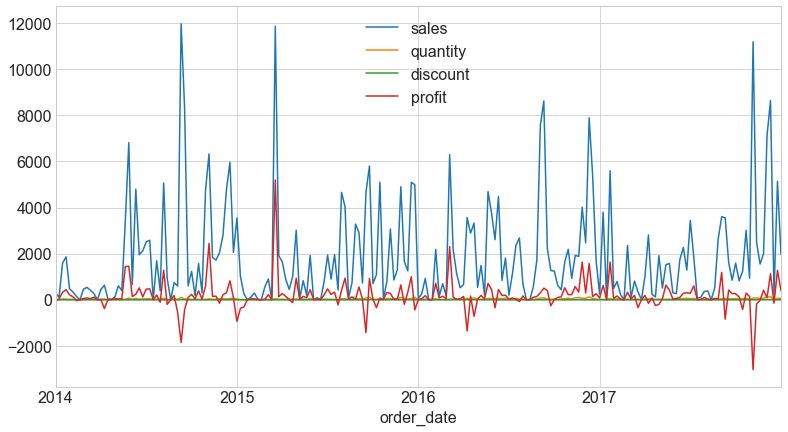

In [5]:
by_week.plot()

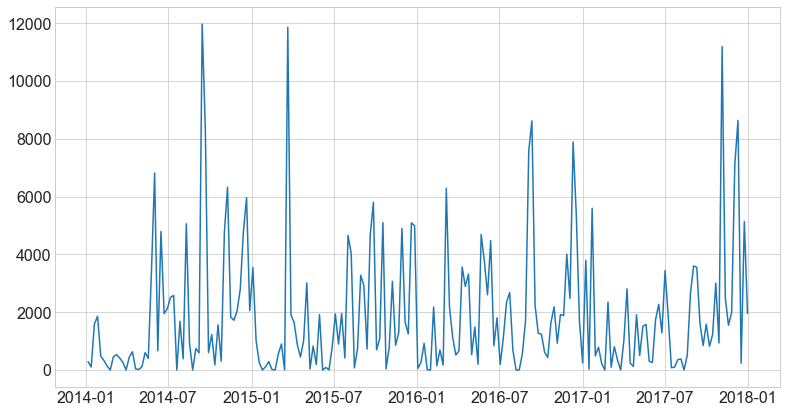

In [6]:
plt.plot(by_week.sales)

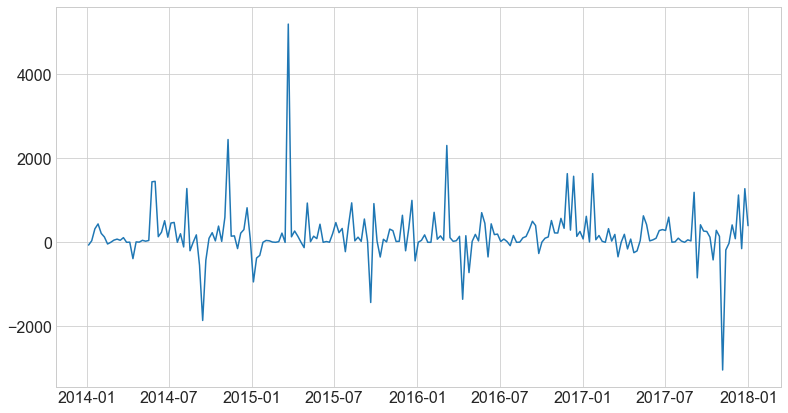

In [7]:
plt.plot(by_week.profit)

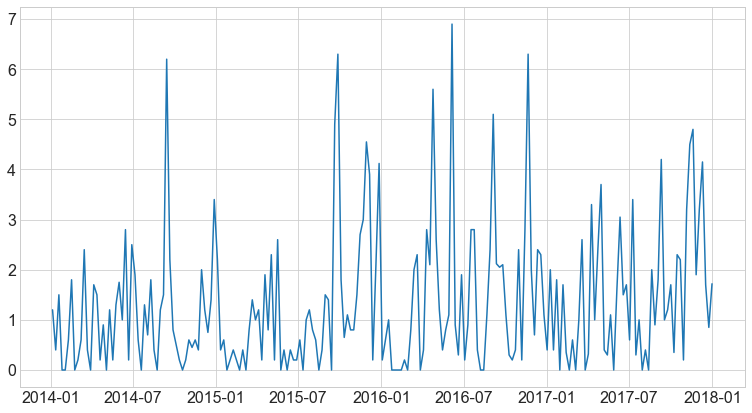

In [8]:
plt.plot(by_week.discount)

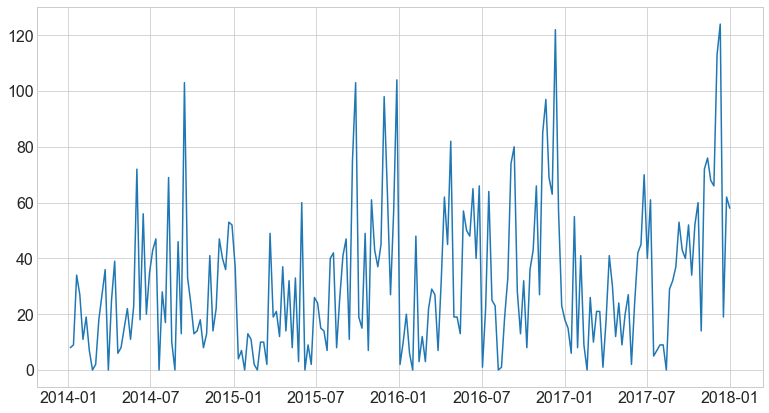

In [9]:
plt.plot(by_week.quantity)

### Takeaways:
- There seems to be seasonality: we can split by year
- Higher peaks on the second half of the year
- Discount, Quantity and Sales have similar peaks
- Profit does not look like the other three variables

----
## Split by week dataframe manually

We will split by year as there seems to be seasonality

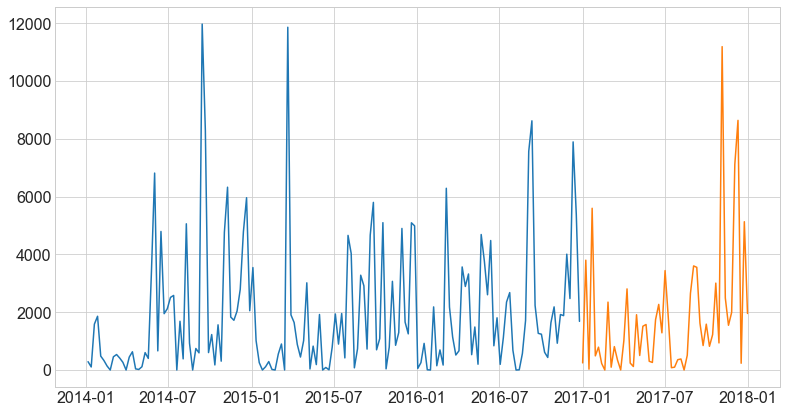

In [10]:
train = by_week[:'2016'] # 2014 - 2016 roughly 75%
test = by_week['2017'] # 2017 roughly 25%

plt.plot(train.index, train.sales)
plt.plot(test.index, test.sales)


### Assign "y" with sales for visualizations

In [11]:
y = train.sales
y.head()

order_date
2014-01-05     288.060
2014-01-12     105.314
2014-01-19    1587.224
2014-01-26    1859.400
2014-02-02     481.250
Freq: W-SUN, Name: sales, dtype: float64

### Average sales by month

[Text(0.5, 1.0, 'Average Monthly Sales'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Value USD')]

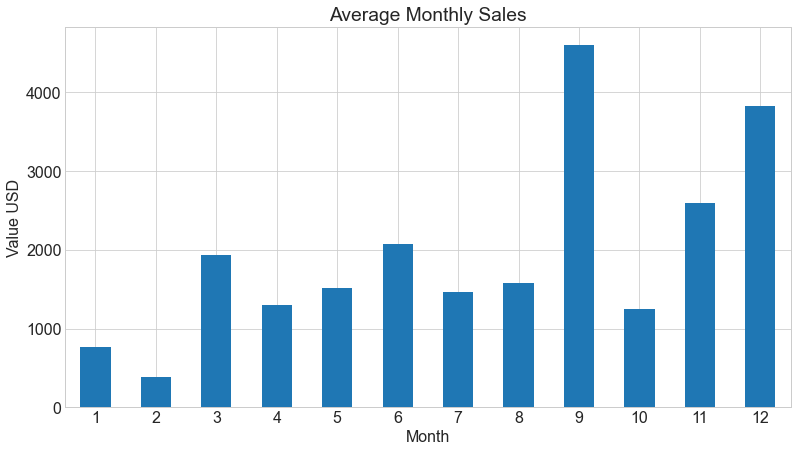

In [12]:
ax = train.groupby(train.index.month).sales.mean().plot.bar()
ax.tick_params('x', rotation=0)
ax.set(title='Average Monthly Sales', xlabel='Month', ylabel='Value USD')

There are some months that a have a very high average sales:
- September is the highest overall
- December is expected to be high as it is aroung the Hollidays
- November is third. expected as there is a lot of travel and get togethers for Thanksgiving holliday
- June and March are forth and fifth respectively, spring break and summer vacation, also could be expected
- February is the lowest of them all. It is the shortest month, and comes after some of the highest spending months 

<AxesSubplot:title={'center':'Average Monthly Sales'}, xlabel='order_date'>

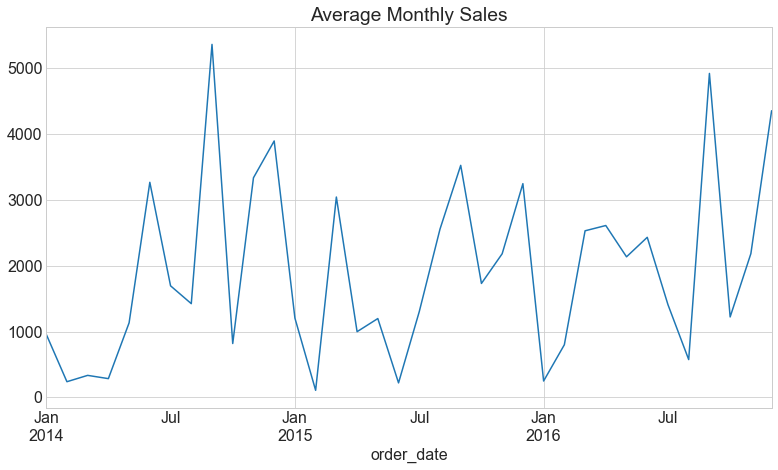

In [13]:
y.resample('M').mean().plot(title='Average Monthly Sales')

You can see more of the same in the three year plot

### Average sales biweekly

<AxesSubplot:title={'center':'Average Bi-Weekly Sales'}, xlabel='order_date'>

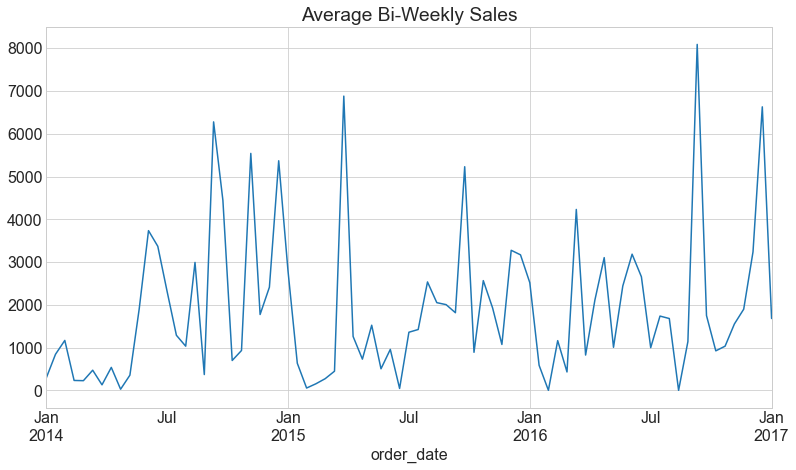

In [14]:
y.resample('2w').mean().plot(title='Average Bi-Weekly Sales')

A bit of a different view, but very similar results. On 2014 you can see that there is a peak the last two weeks of November and December, that falls on what we had mentioned before about the holidays.

#### Average Sales Quarterly

<AxesSubplot:title={'center':'Average Quarterly Sales'}, xlabel='order_date'>

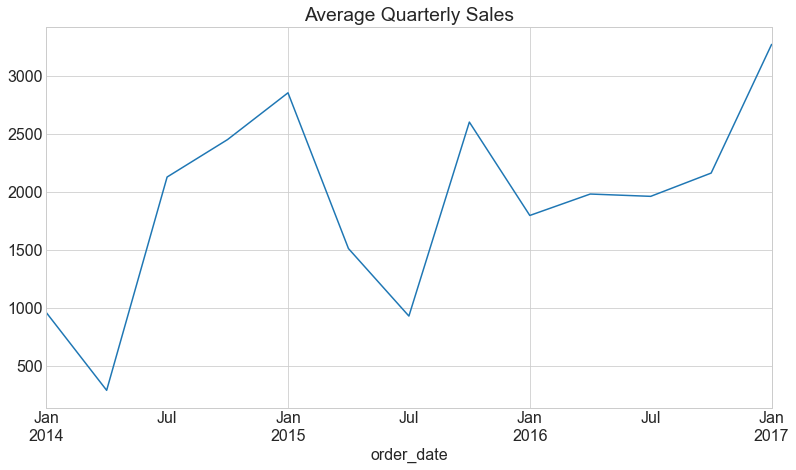

In [15]:
y.resample('3M').mean().plot(title='Average Quarterly Sales')

### Average sales weekly, monthly, yearly

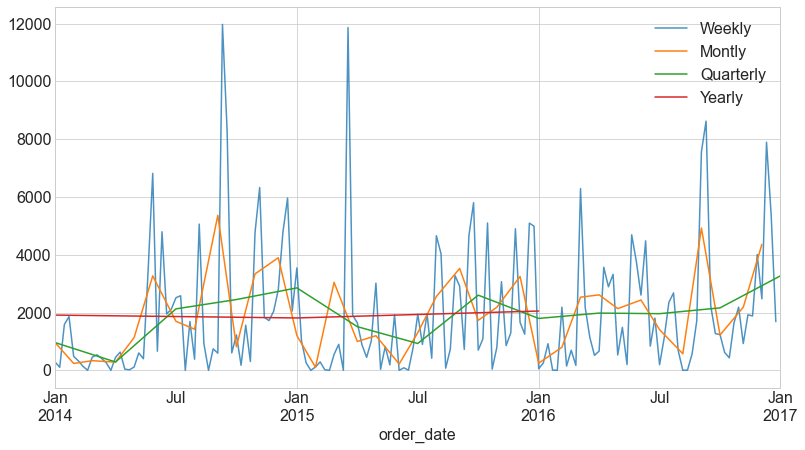

In [16]:
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('3M').mean().plot(label='Quarterly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()

On this chart we can see three different average plots:
- Weekly
- Monthly
- Yearly

What is revealing is that the yearly average stays the same around the $2,000 USD mark.
<p>There is more of a variance week by week.

### Weekly change in Sales

<AxesSubplot:title={'center':'Weekly Change in Sales'}, xlabel='order_date'>

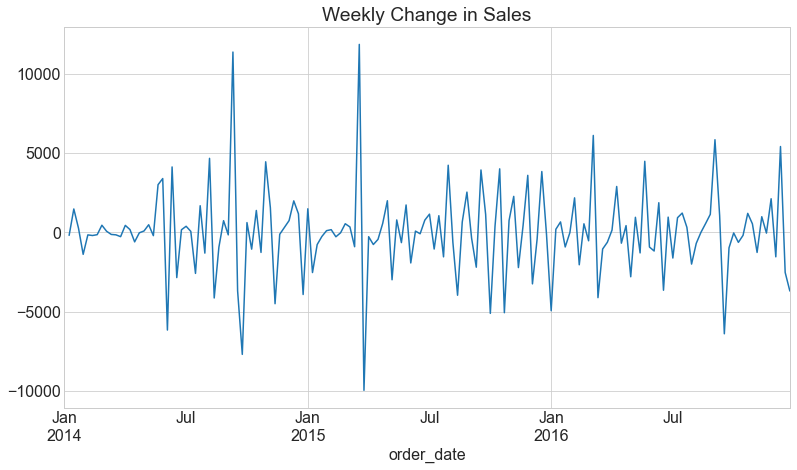

In [17]:
y.resample('W').mean().diff().plot(title='Weekly Change in Sales')

This weekly difference plot ties on what we mentioned about the weekly variance. 
- This plot gives is how much is the sales difference week after week
- The big changes in the second half of 2014 and first half of 2015

### Monthly change in Sales

<AxesSubplot:title={'center':'Monthly Change in Sales'}, xlabel='order_date'>

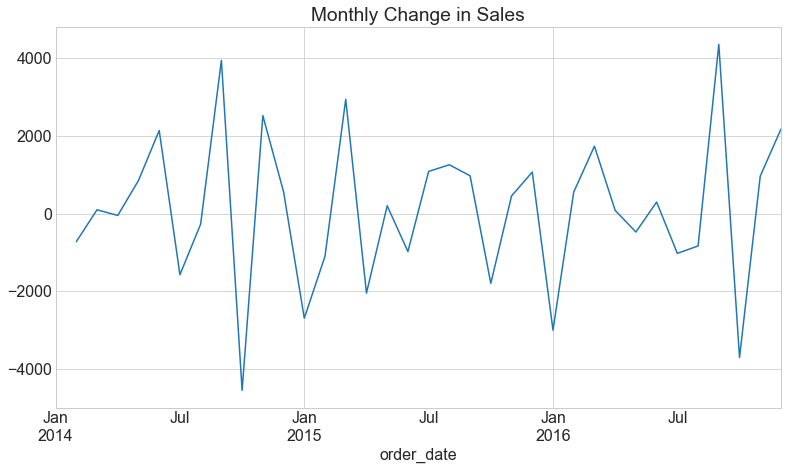

In [18]:
y.resample('M').mean().diff().plot(title='Monthly Change in Sales')

Continuing with the previous plot:
- the changes around September to October as we had seen on the monthly bar chart
- the peak mentioned earlier in the second half of 2014 still shows
- the peak mentioned earlier in the first half of 2015 does not look as dramatic

### Seasonal Plot

<AxesSubplot:title={'center':'Seasonal Plot'}, xlabel='order_date'>

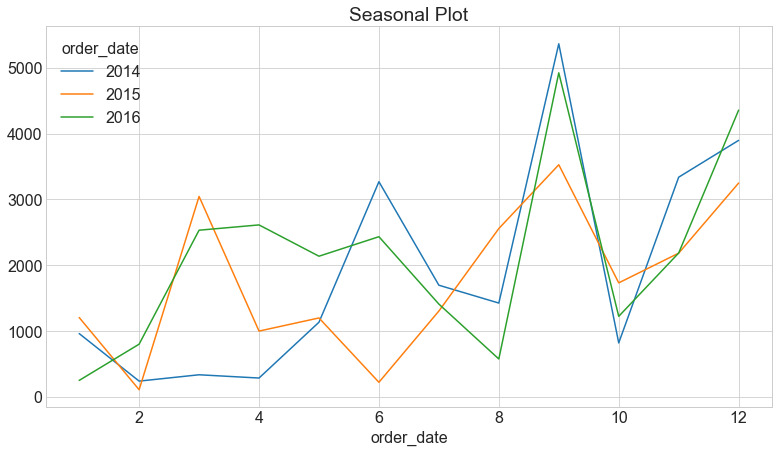

In [19]:
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot')

This Seasonal plot clearly shows a pattern:
- We can see February is a low month
- May and July are very regular months
- Last quarter has the most regularity: 
    - Aug to Sep is an up move
    - Sep to Oct is a down move
    - Oct to Dec is an up move

### Autocorrelation Plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

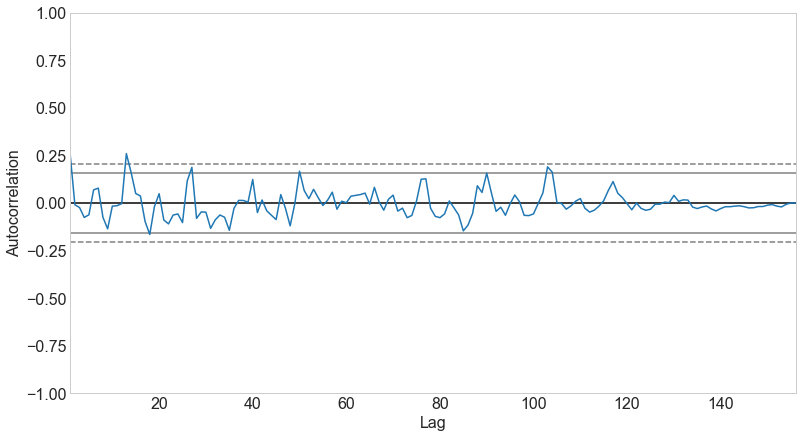

In [20]:
pd.plotting.autocorrelation_plot(train.sales.resample('W').mean())

### Seasonal Decomposition

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

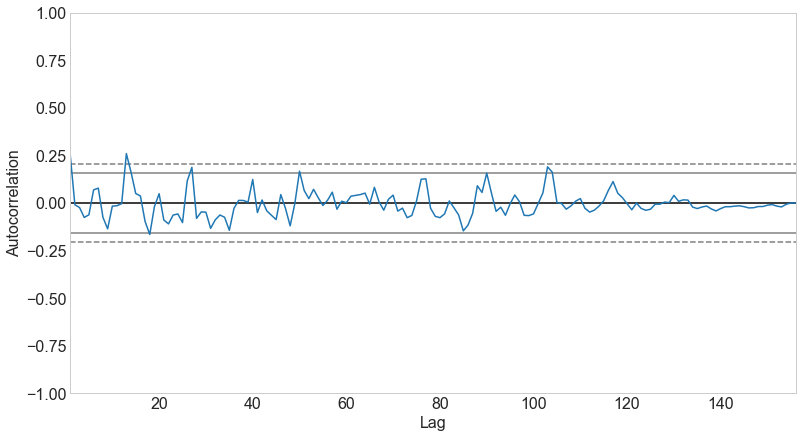

In [21]:
pd.plotting.autocorrelation_plot(y)

<AxesSubplot:xlabel='order_date'>

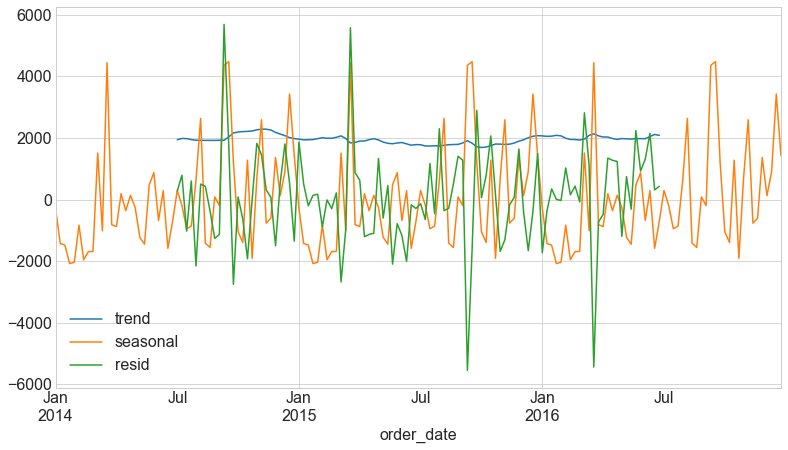

In [22]:
y = train.sales.resample('W').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.iloc[:, 1:].plot()


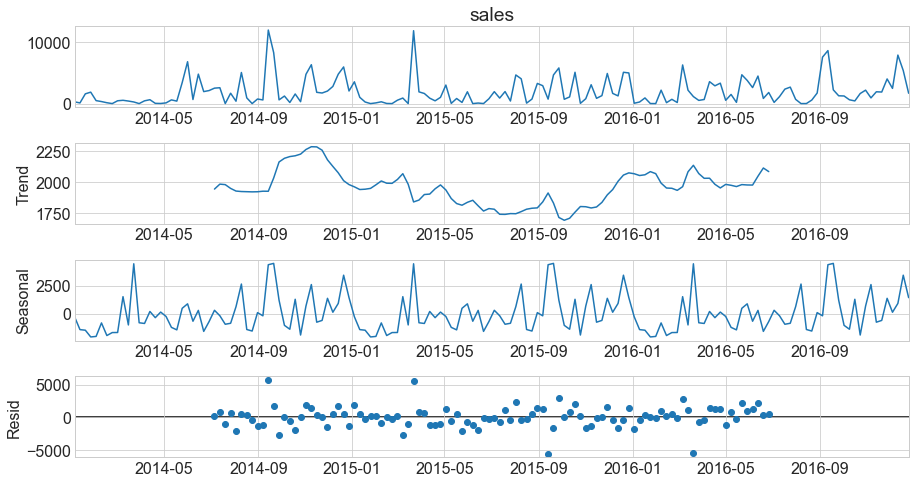

In [23]:
result.plot()
None

#### Takeaways from decomposition:
- Trend has a $500 variance
- Some abnormalities with very high peaks, over $10,000
- Seasonal looks very clean

---
## Split and Plot the following Region subsets:
- East
- West 
- Central 
- South 
  

### East


Split the east dataframe manually

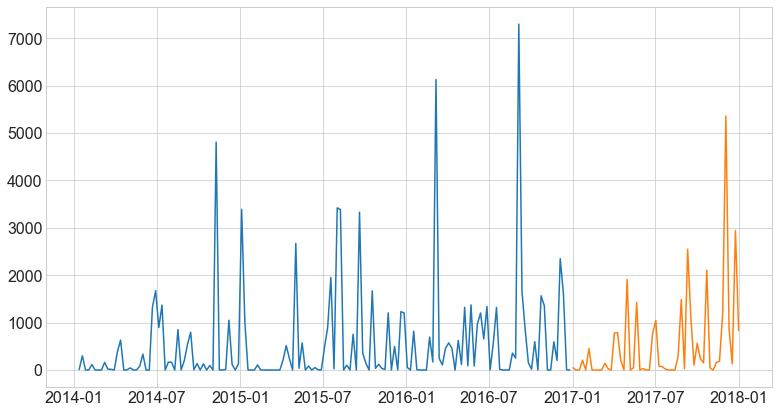

In [24]:
train = east[:'2016'] # 2014 - 2016 roughly 75%
test = east['2017'] # 2017 roughly 25%
plt.plot(train.index, train.sales)
plt.plot(test.index, test.sales)

#### Average Monthly Sales 

[Text(0.5, 1.0, 'Average Monthly Sales East Region'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Value USD')]

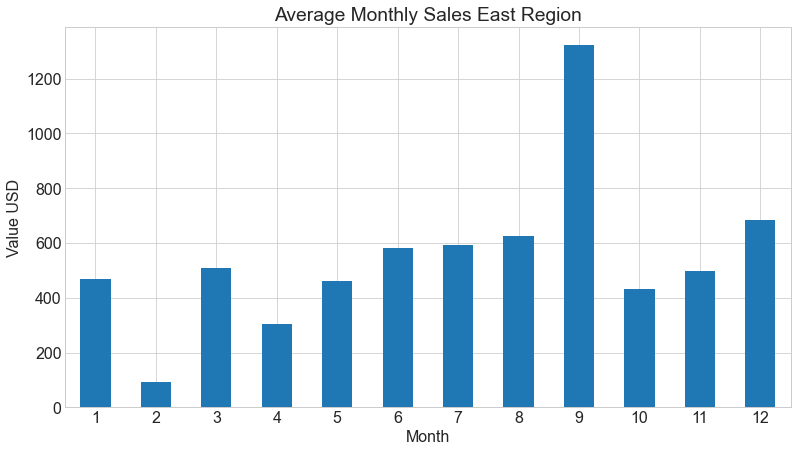

In [25]:
ax = train.groupby(train.index.month).sales.mean().plot.bar()
ax.tick_params('x', rotation=0)
ax.set(title='Average Monthly Sales East Region', xlabel='Month', ylabel='Value USD')

In [26]:
y = train.sales
y.head()

order_date
2014-01-12      9.940
2014-01-19    299.964
2014-01-26      0.000
2014-02-02      0.000
2014-02-09    115.360
Freq: W-SUN, Name: sales, dtype: float64

<AxesSubplot:title={'center':'Weekly Average East Region'}, xlabel='order_date'>

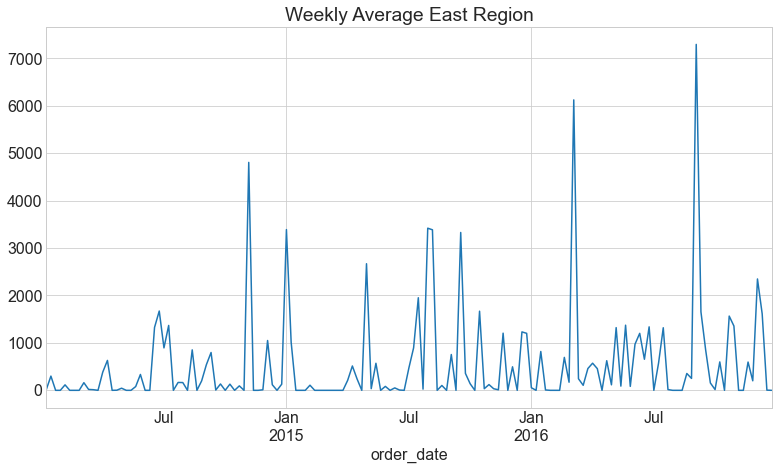

In [27]:
y.resample('W').mean().plot(title = 'Weekly Average East Region')

<AxesSubplot:title={'center':'Quarterly Average East Region'}, xlabel='order_date'>

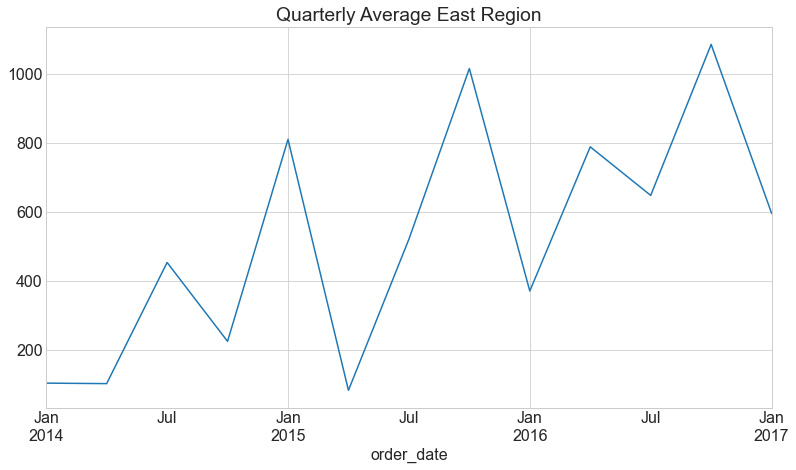

In [28]:
y.resample('3M').mean().plot(title = 'Quarterly Average East Region')

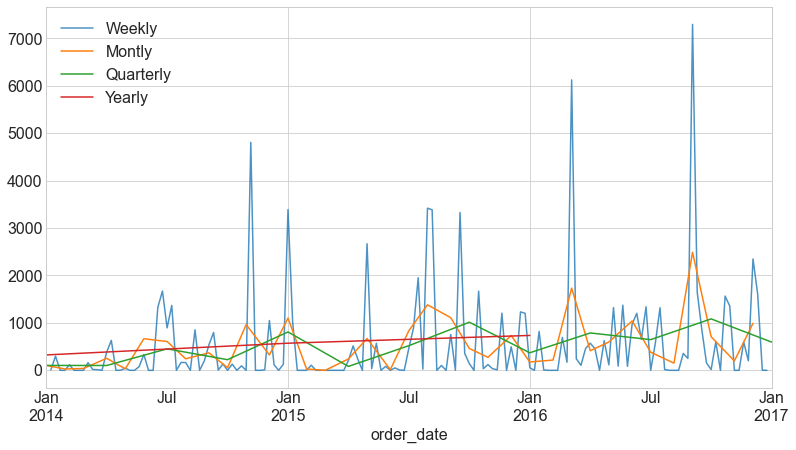

In [29]:
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('3M').mean().plot(label='Quarterly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()

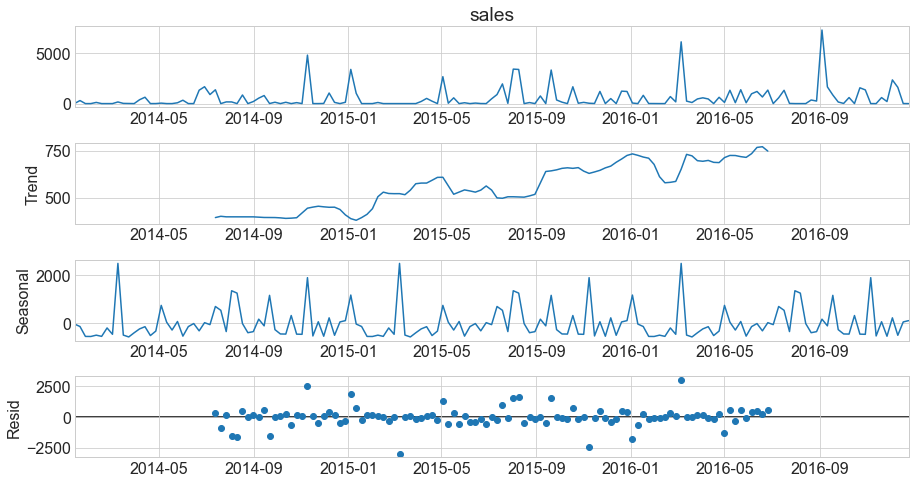

In [30]:
result = sm.tsa.seasonal_decompose(y)
result.plot()
None

### West

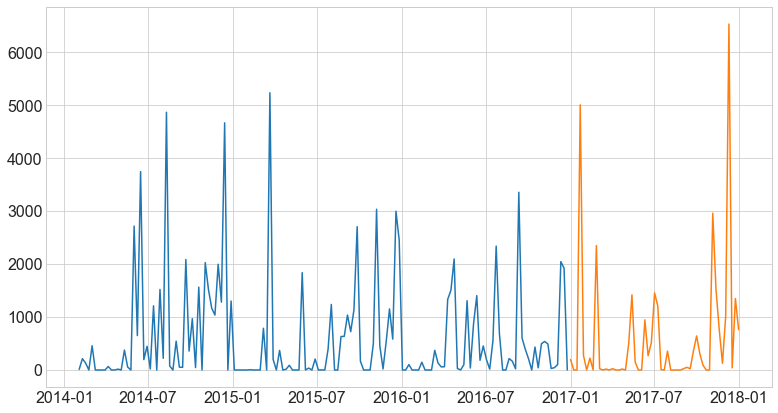

In [31]:
train = west[:'2016'] # 2014 - 2016 roughly 75%
test = west['2017'] # 2017 roughly 25%
plt.plot(train.index, train.sales)
plt.plot(test.index, test.sales)

[Text(0.5, 1.0, 'Average Monthly Sales West Region'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Value USD')]

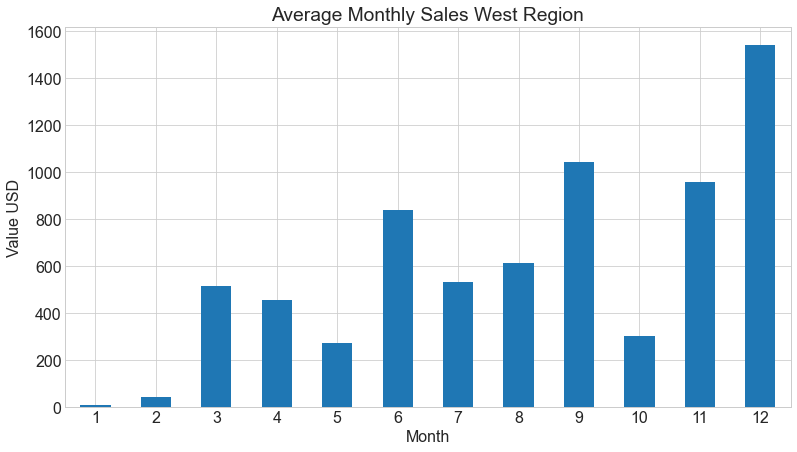

In [32]:
ax = train.groupby(train.index.month).sales.mean().plot.bar()
ax.tick_params('x', rotation=0)
ax.set(title='Average Monthly Sales West Region', xlabel='Month', ylabel='Value USD')

In [33]:
y = train.sales
y.head()

order_date
2014-02-02     12.350
2014-02-09    214.248
2014-02-16    129.568
2014-02-23      0.000
2014-03-02    457.568
Freq: W-SUN, Name: sales, dtype: float64

<AxesSubplot:title={'center':'Average Weekly Sales West Region'}, xlabel='order_date'>

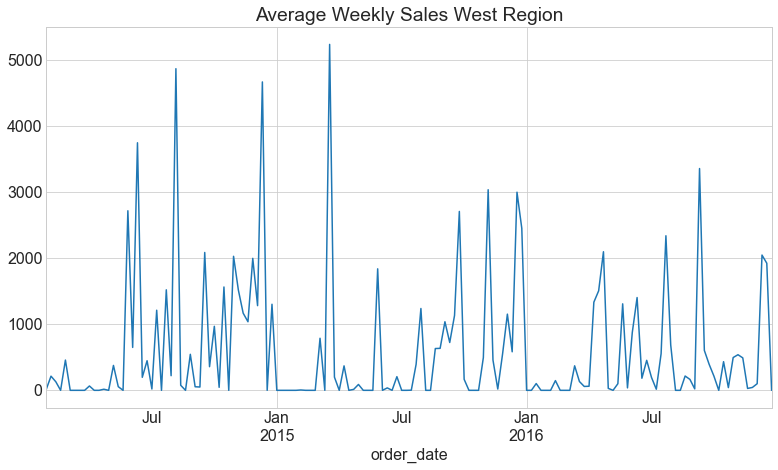

In [34]:
y.resample('W').mean().plot(title='Average Weekly Sales West Region')

<AxesSubplot:title={'center':'Average Quarterly Sales West Region'}, xlabel='order_date'>

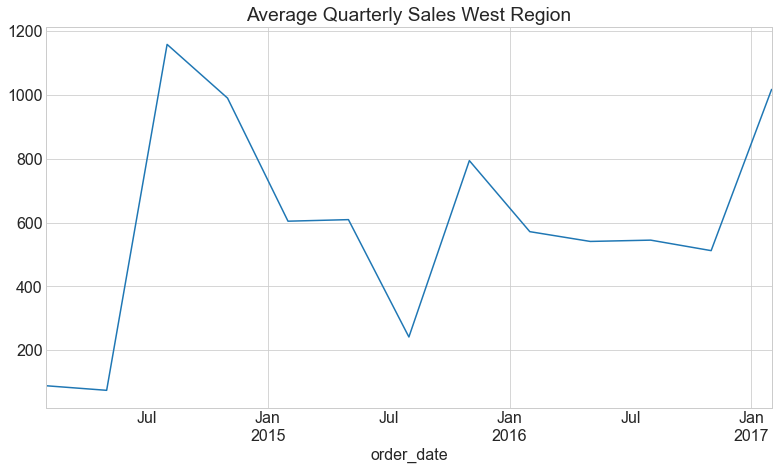

In [35]:
y.resample('3M').mean().plot(title='Average Quarterly Sales West Region')

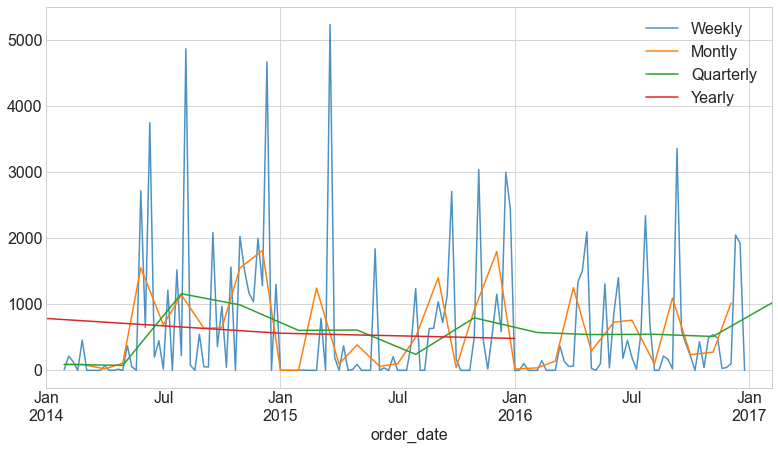

In [36]:
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('3M').mean().plot(label='Quarterly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()

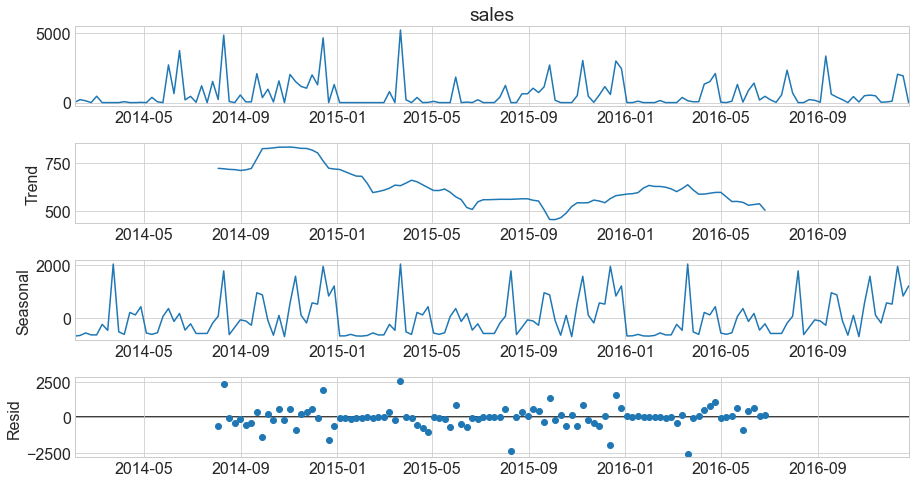

In [37]:
result = sm.tsa.seasonal_decompose(y)
result.plot()
None

### Central

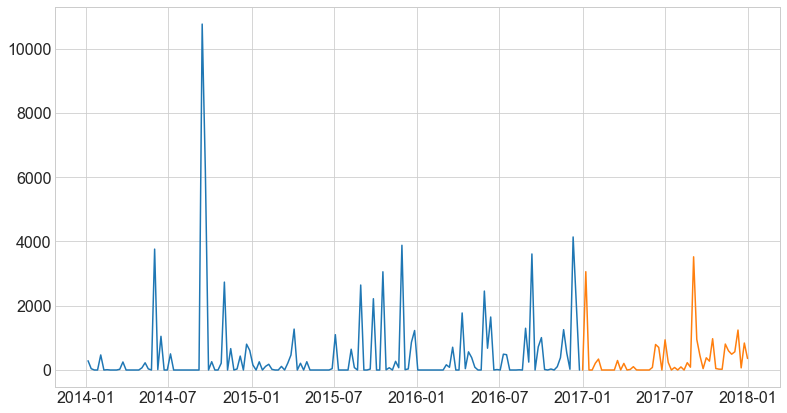

In [38]:
train = central[:'2016'] # 2014 - 2016 roughly 75%
test = central['2017'] # 2017 roughly 25%
plt.plot(train.index, train.sales)
plt.plot(test.index, test.sales)


[Text(0.5, 1.0, 'Average Monthly Sales Central Region'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Value USD')]

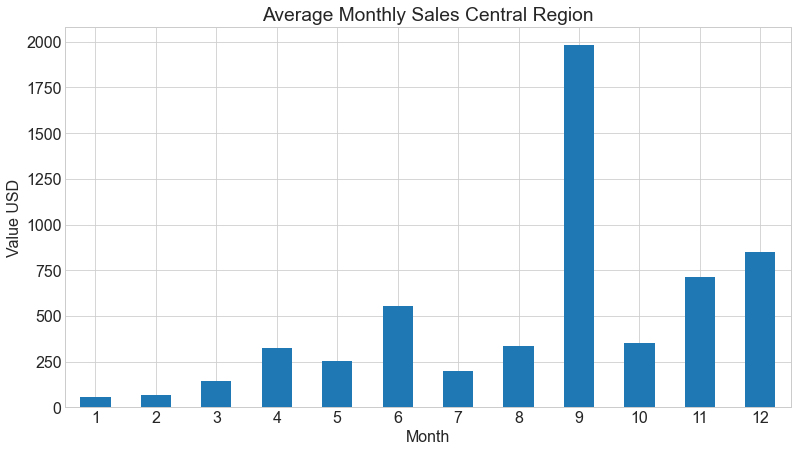

In [39]:
ax = train.groupby(train.index.month).sales.mean().plot.bar()
ax.tick_params('x', rotation=0)
ax.set(title='Average Monthly Sales Central Region', xlabel='Month', ylabel='Value USD')

In [40]:
y = train.sales
y.head()

order_date
2014-01-05    288.060
2014-01-12     40.544
2014-01-19      0.000
2014-01-26      0.000
2014-02-02    468.900
Freq: W-SUN, Name: sales, dtype: float64

<AxesSubplot:title={'center':'Average Weekly Sales Central Region'}, xlabel='order_date'>

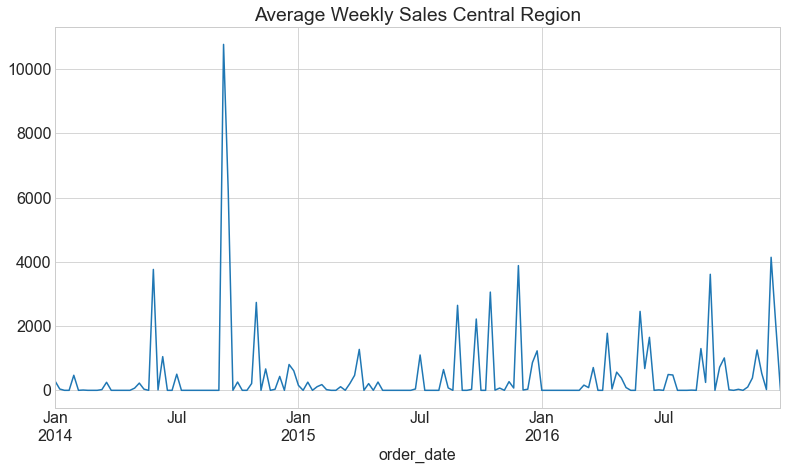

In [41]:
y.resample('W').mean().plot(title='Average Weekly Sales Central Region')

<AxesSubplot:title={'center':'Average Quarterly Sales Central Region'}, xlabel='order_date'>

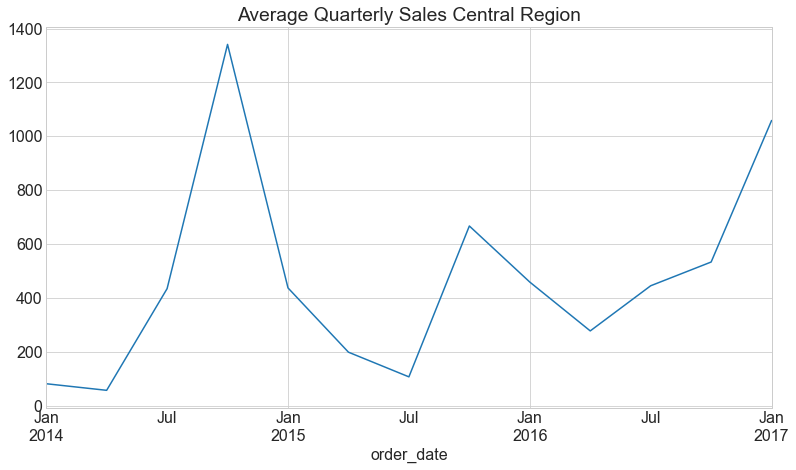

In [42]:
y.resample('3M').mean().plot(title='Average Quarterly Sales Central Region')

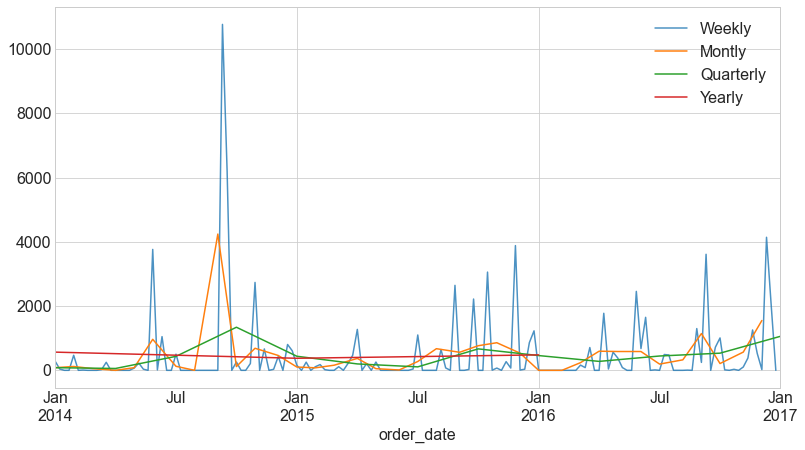

In [43]:
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('3M').mean().plot(label='Quarterly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()

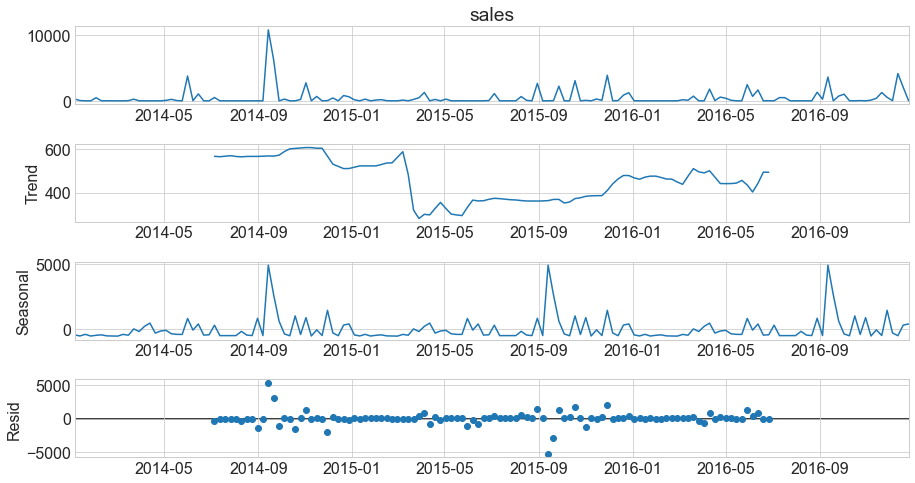

In [44]:
result = sm.tsa.seasonal_decompose(y)
result.plot()
None

### South

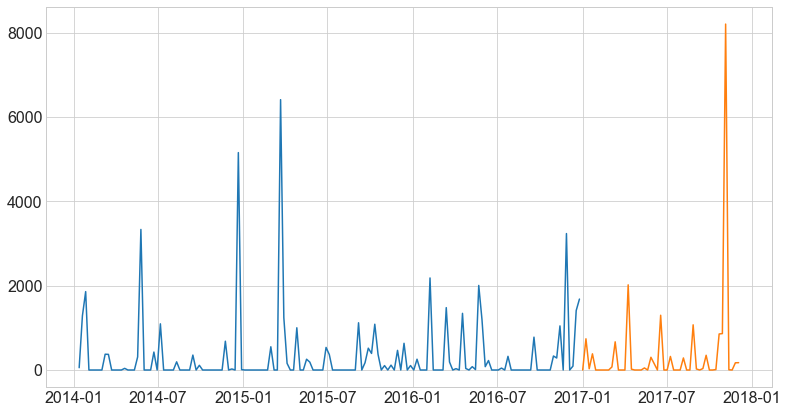

In [45]:
train = south[:'2016'] # 2014 - 2016 roughly 75%
test = south['2017'] # 2017 roughly 25%
plt.plot(train.index, train.sales)
plt.plot(test.index, test.sales)

[Text(0.5, 1.0, 'Average Monthly Sales South Region'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Value USD')]

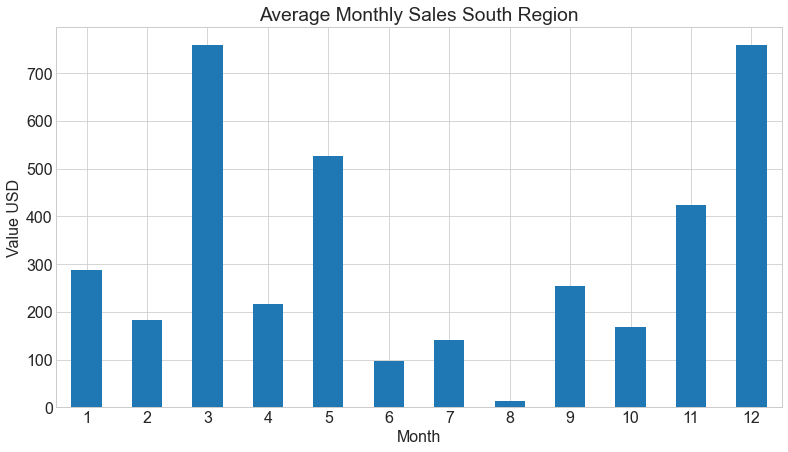

In [46]:
ax = train.groupby(train.index.month).sales.mean().plot.bar()
ax.tick_params('x', rotation=0)
ax.set(title='Average Monthly Sales South Region', xlabel='Month', ylabel='Value USD')

In [47]:
y = train.sales
y.head()

order_date
2014-01-12      54.83
2014-01-19    1287.26
2014-01-26    1859.40
2014-02-02       0.00
2014-02-09       0.00
Freq: W-SUN, Name: sales, dtype: float64

<AxesSubplot:title={'center':'Average Weekly Sales South Region'}, xlabel='order_date'>

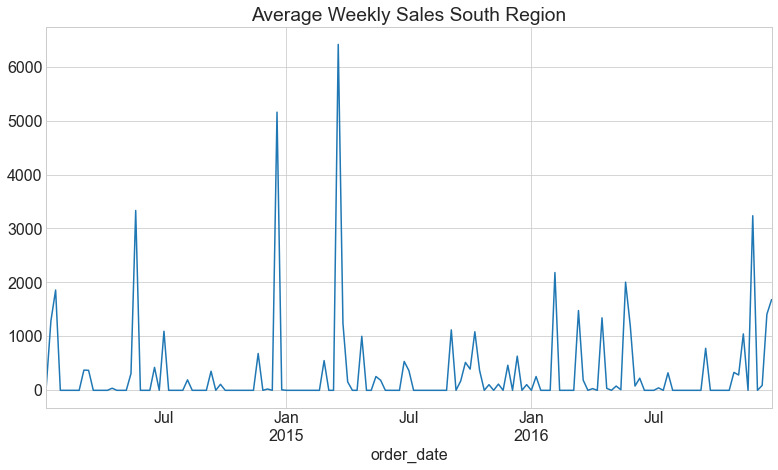

In [48]:
y.resample('W').mean().plot(title='Average Weekly Sales South Region')

<AxesSubplot:title={'center':'Average Quarterly Sales South Region'}, xlabel='order_date'>

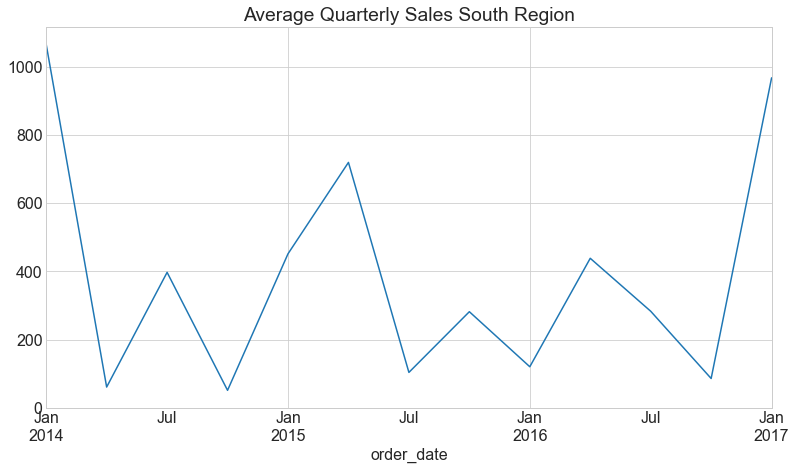

In [49]:
y.resample('3M').mean().plot(title='Average Quarterly Sales South Region')

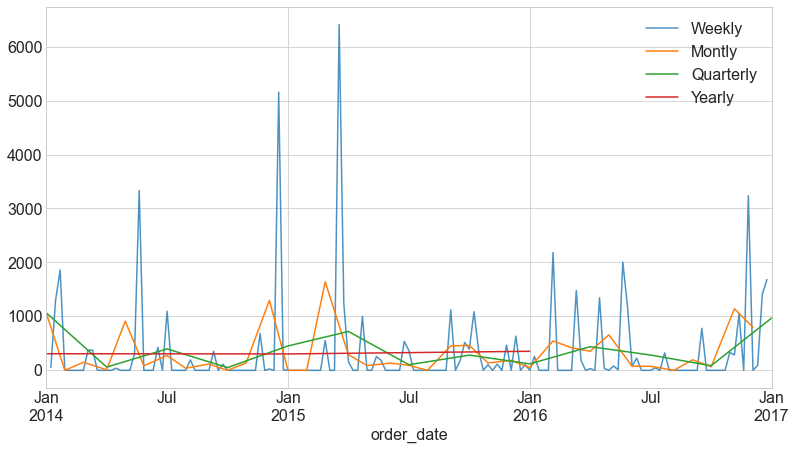

In [50]:
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('3M').mean().plot(label='Quarterly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()

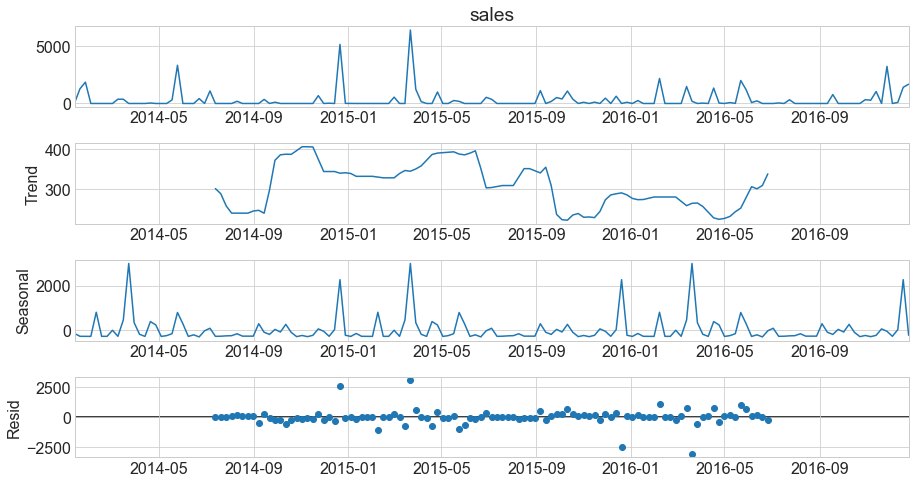

In [51]:
result = sm.tsa.seasonal_decompose(y)
result.plot()
None

---
## Split and Plot the following Category subsets:

- Office Supplies
- Furniture 
- Technology

### Office Supplies 

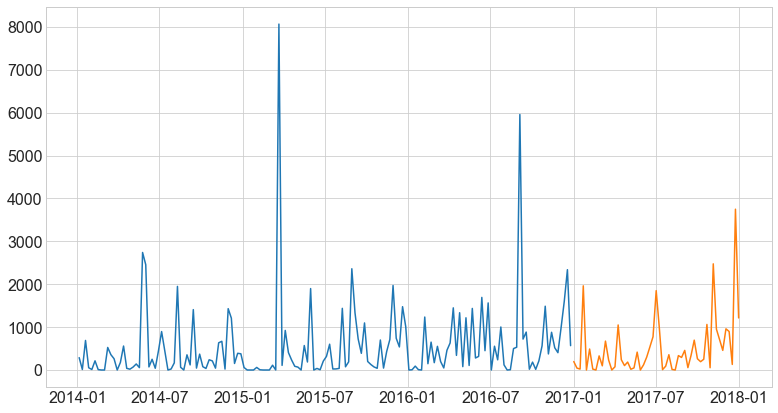

In [52]:
train = office_supplies[:'2016'] # 2014 - 2016 roughly 75%
test = office_supplies['2017'] # 2017 roughly 25%
plt.plot(train.index, train.sales)
plt.plot(test.index, test.sales)

[Text(0.5, 1.0, 'Office Supplies Average Monthly Sales'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Value USD')]

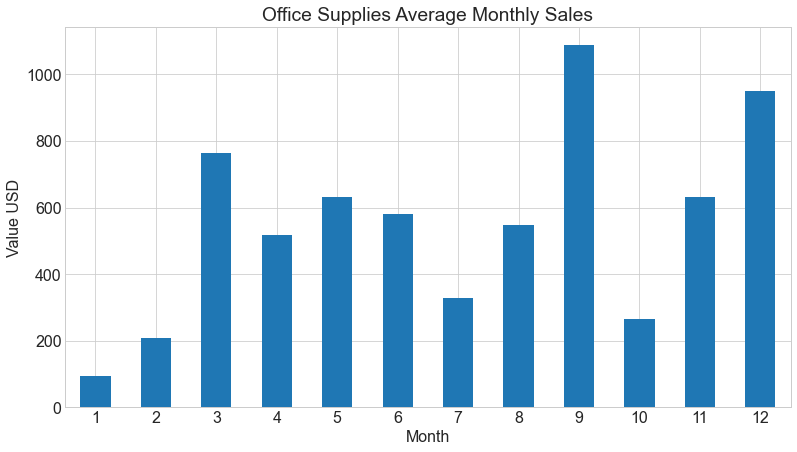

In [53]:
ax = train.groupby(train.index.month).sales.mean().plot.bar()
ax.tick_params('x', rotation=0)
ax.set(title='Office Supplies Average Monthly Sales', xlabel='Month', ylabel='Value USD')

In [54]:
y = train.sales
y.head()

order_date
2014-01-05    288.060
2014-01-12     12.234
2014-01-19    689.180
2014-01-26     52.930
2014-02-02     12.350
Freq: W-SUN, Name: sales, dtype: float64

<AxesSubplot:title={'center':'Office Supplies Average Weekly Sales'}, xlabel='order_date'>

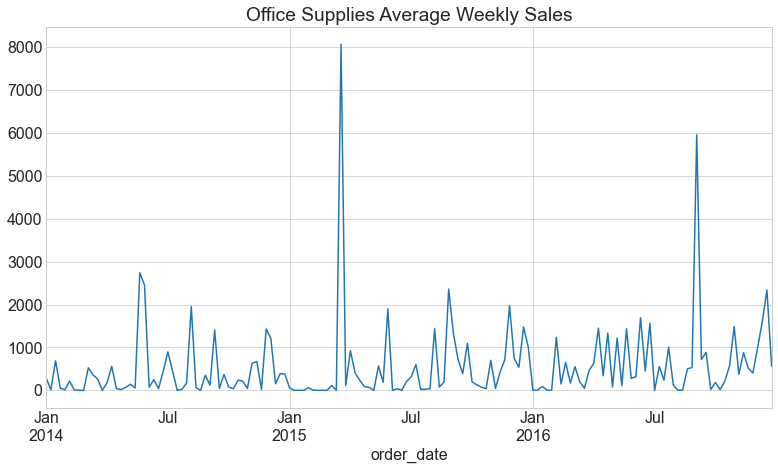

In [55]:
y.resample('W').mean().plot(title='Office Supplies Average Weekly Sales')

<AxesSubplot:title={'center':'Office Supplies Average Quarterly Sales'}, xlabel='order_date'>

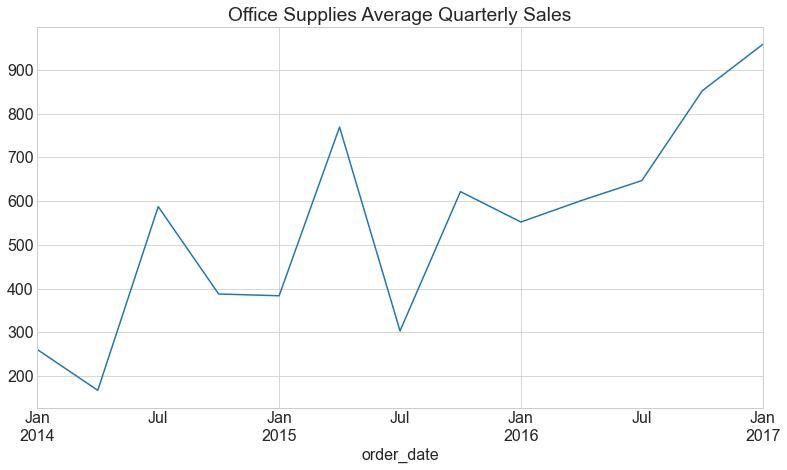

In [56]:
y.resample('3M').mean().plot(title='Office Supplies Average Quarterly Sales')

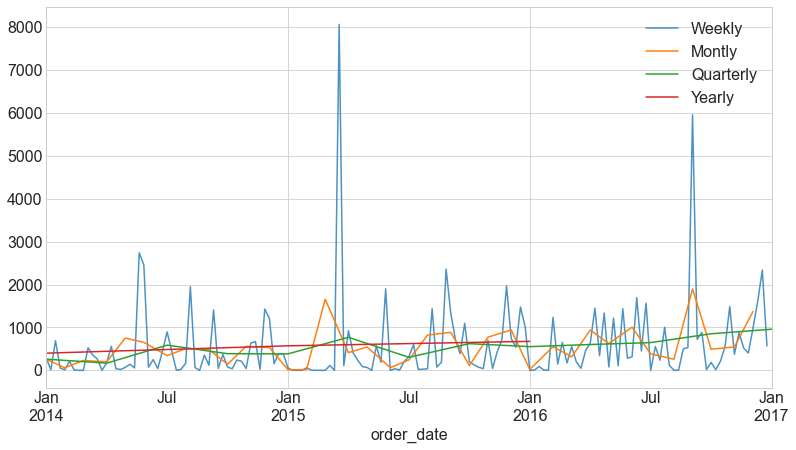

In [57]:
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('3M').mean().plot(label='Quarterly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()

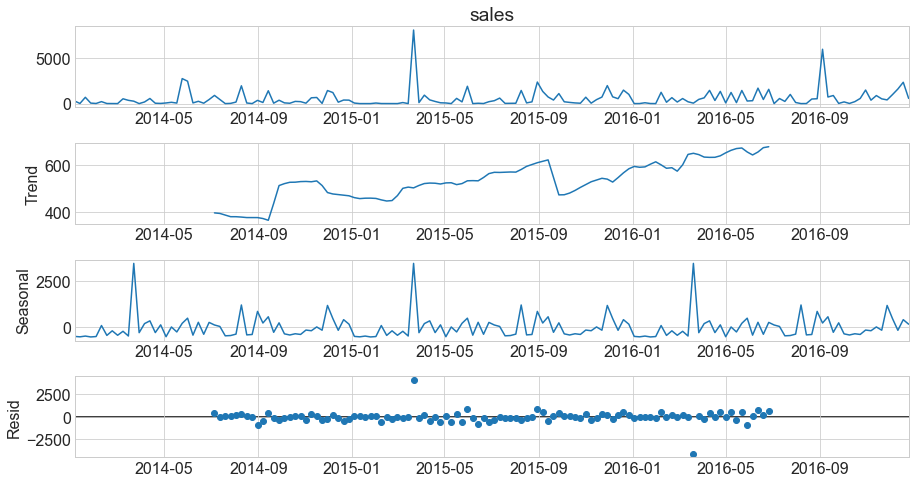

In [58]:
result = sm.tsa.seasonal_decompose(y)
result.plot()
None

### Furniture

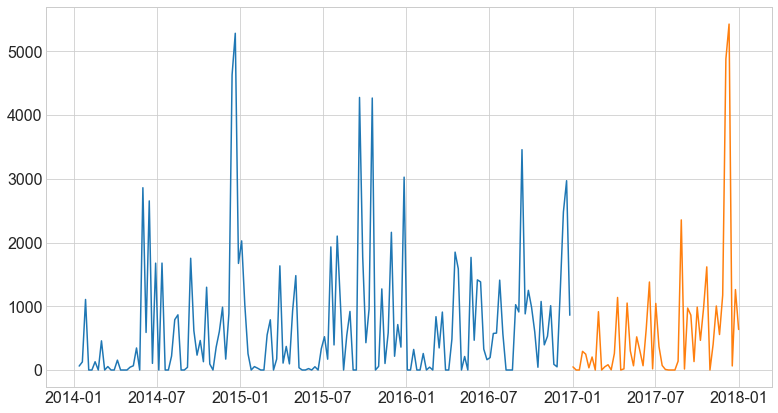

In [59]:
train = furniture[:'2016'] # 2014 - 2016 roughly 75%
test = furniture['2017'] # 2017 roughly 25%
plt.plot(train.index, train.sales)
plt.plot(test.index, test.sales)

[Text(0.5, 1.0, 'Furniture Average Monthly Sales'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Value USD')]

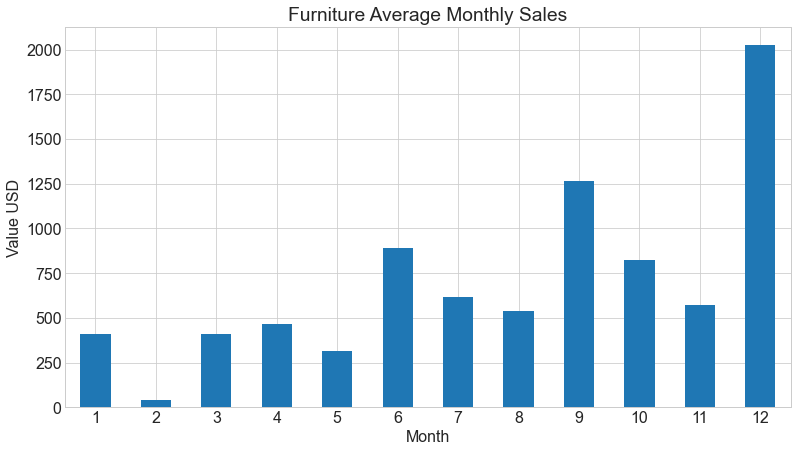

In [60]:
ax = train.groupby(train.index.month).sales.mean().plot.bar()
ax.tick_params('x', rotation=0)
ax.set(title='Furniture Average Monthly Sales', xlabel='Month', ylabel='Value USD')

In [61]:
y = train.sales
y.head()

order_date
2014-01-12      61.880
2014-01-19     127.104
2014-01-26    1106.540
2014-02-02       0.000
2014-02-09       0.000
Freq: W-SUN, Name: sales, dtype: float64

<AxesSubplot:title={'center':'Furniture Average Weekly Sales'}, xlabel='order_date'>

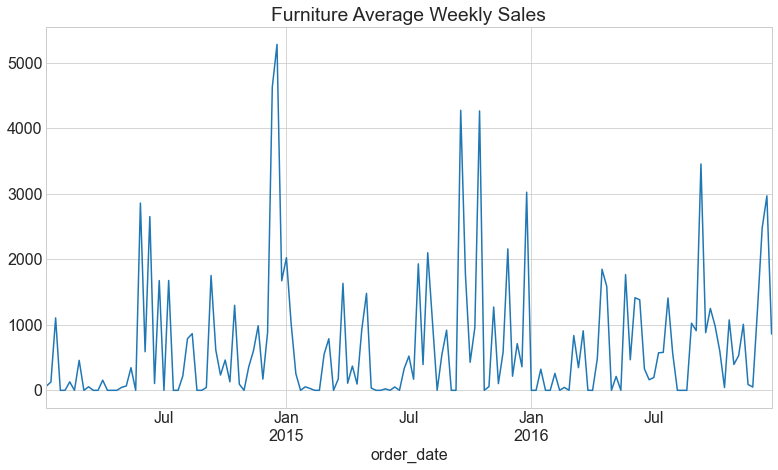

In [62]:
y.resample('W').mean().plot(title='Furniture Average Weekly Sales',)

<AxesSubplot:title={'center':'Furniture Average Quarterly Sales'}, xlabel='order_date'>

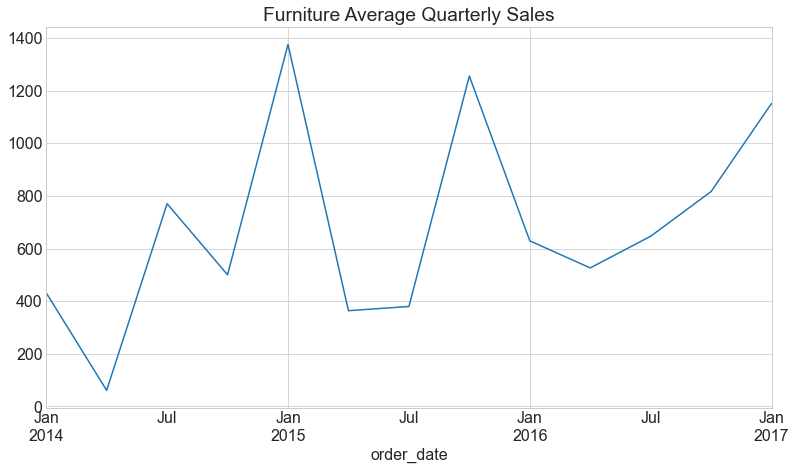

In [63]:
y.resample('3M').mean().plot(title='Furniture Average Quarterly Sales',)

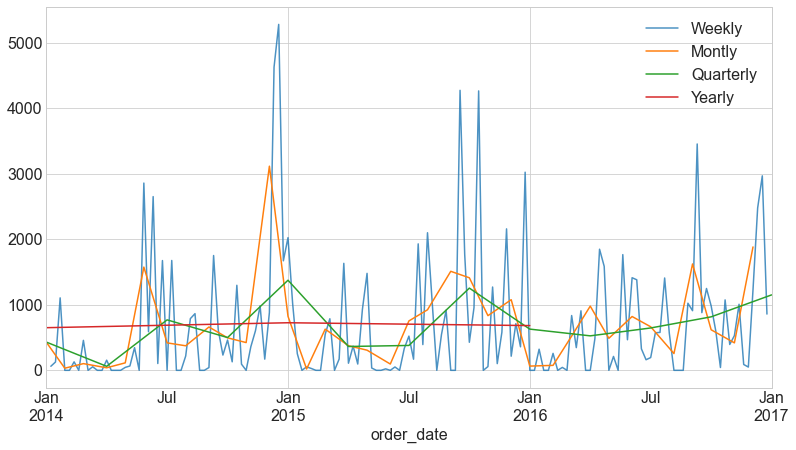

In [64]:
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('3M').mean().plot(label='Quarterly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()

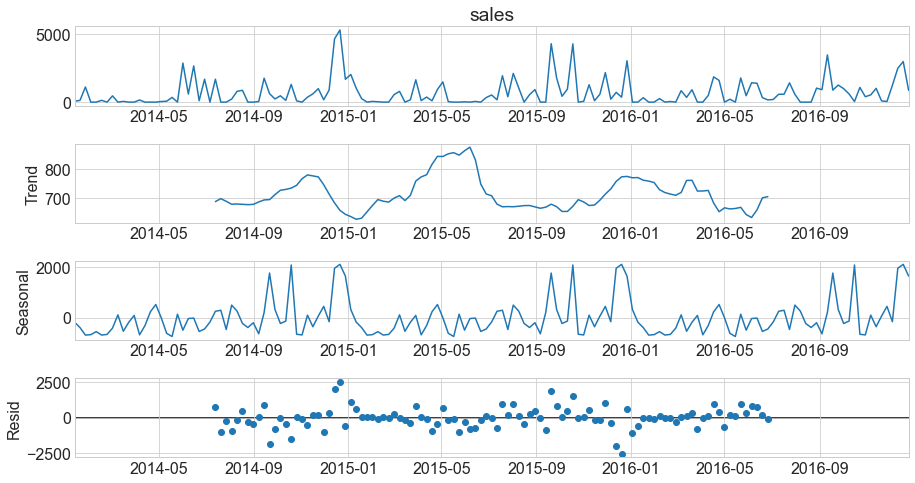

In [65]:
result = sm.tsa.seasonal_decompose(y)
result.plot()
None

### Technology

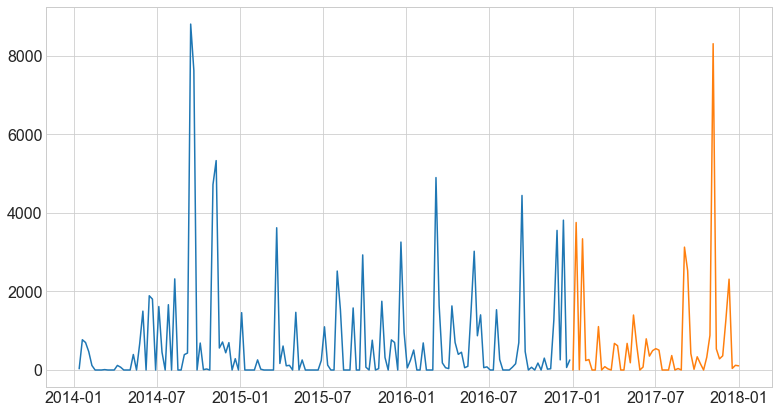

In [66]:
train = technology[:'2016'] # 2014 - 2016 roughly 75%
test = technology['2017'] # 2017 roughly 25%
plt.plot(train.index, train.sales)
plt.plot(test.index, test.sales)


[Text(0.5, 1.0, 'Technology Average Monthly Sales'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Value USD')]

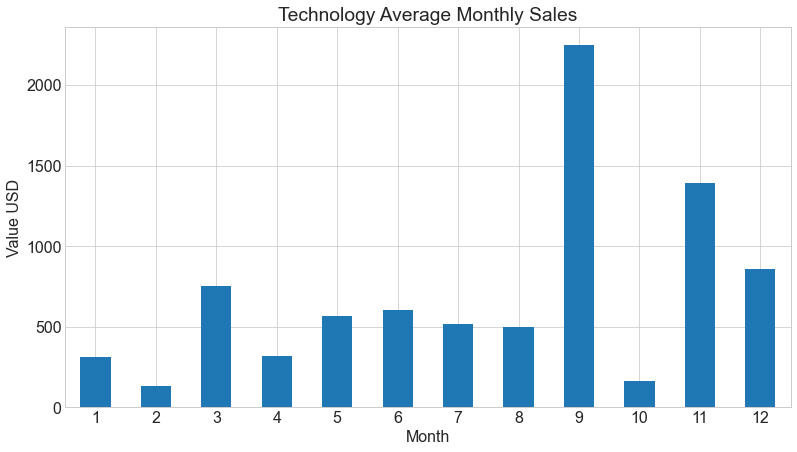

In [67]:
ax = train.groupby(train.index.month).sales.mean().plot.bar()
ax.tick_params('x', rotation=0)
ax.set(title='Technology Average Monthly Sales', xlabel='Month', ylabel='Value USD')

In [68]:
y = train.sales
y.head()

order_date
2014-01-12     31.20
2014-01-19    770.94
2014-01-26    699.93
2014-02-02    468.90
2014-02-09    115.36
Freq: W-SUN, Name: sales, dtype: float64

<AxesSubplot:title={'center':'Technology Average Weekly Sales'}, xlabel='order_date'>

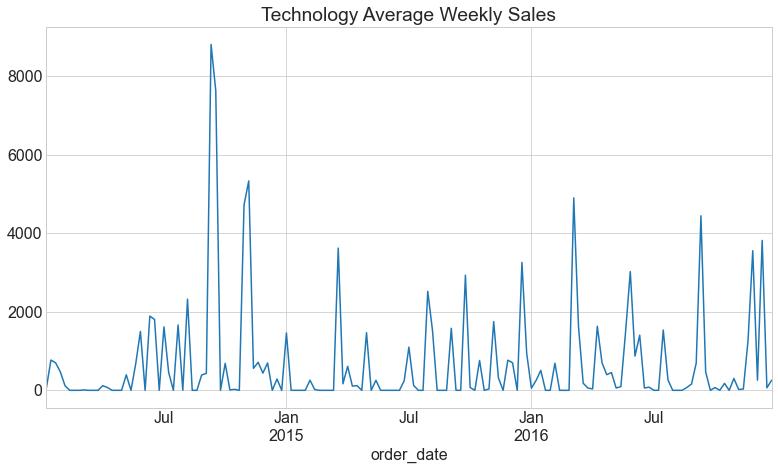

In [69]:
y.resample('W').mean().plot(title = 'Technology Average Weekly Sales')

<AxesSubplot:title={'center':'Technology Average Quarterly Sales'}, xlabel='order_date'>

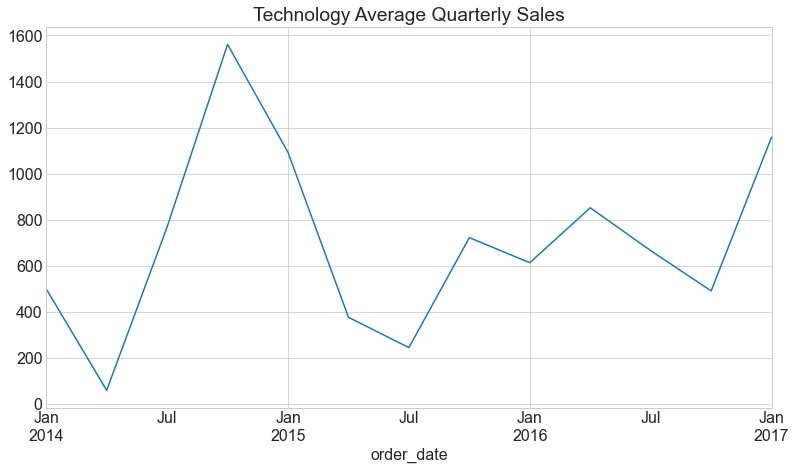

In [70]:
y.resample('3M').mean().plot(title = 'Technology Average Quarterly Sales')

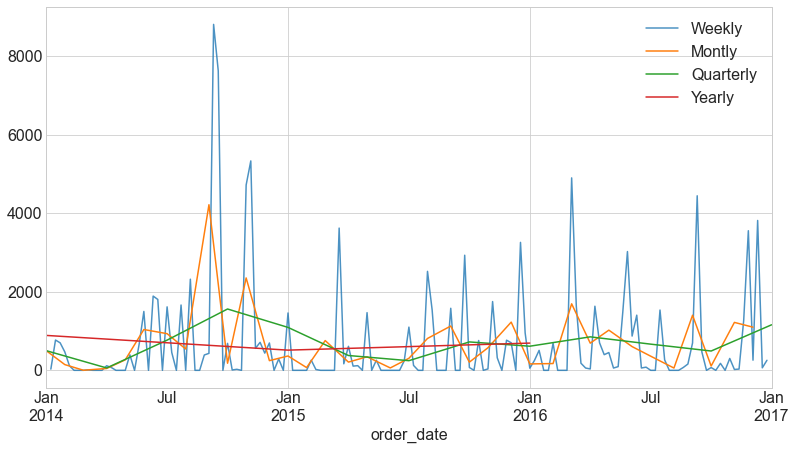

In [71]:
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('3M').mean().plot(label='Quarterly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()

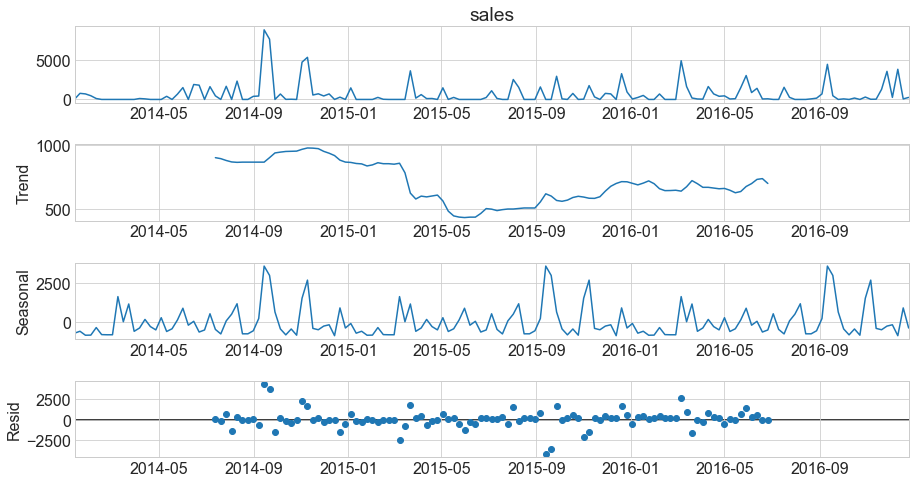

In [72]:
result = sm.tsa.seasonal_decompose(y)
result.plot()
None

---
## Exploring discounts
Since there are some really high spikes on September we would like to explore discounts and see if they match 

In [73]:
by_week.discount.value_counts()

0.00    31
0.20    19
0.40    18
0.60    10
1.00     8
        ..
3.00     1
4.55     1
3.90     1
4.12     1
1.72     1
Name: discount, Length: 69, dtype: int64

Since we had sum by week the discounts look ridiculous, but we can get an idea of how many discounts are on each week.
<p>Weeks with a 1.0 does not mean there was 100% discount. It would more like 5 days of 20%. 
<p>It will look a little odd, but it'll give us an idea of how large where the discounts in each week.

### Split the dataframe

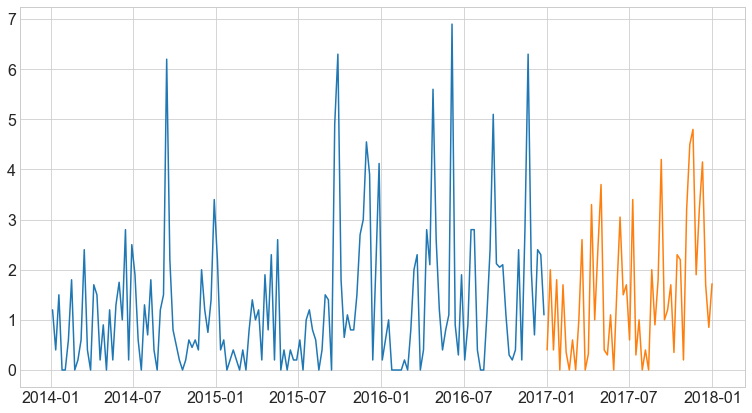

In [74]:
train = by_week[:'2016'] # 2014 - 2016 roughly 75%
test = by_week['2017'] # 2017 roughly 25%
plt.plot(train.index, train.discount)
plt.plot(test.index, test.discount)

#### Monthly Discount's Sum Values. Averaged between years 

[Text(0.5, 1.0, 'Average Monthly Discounts'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Value USD')]

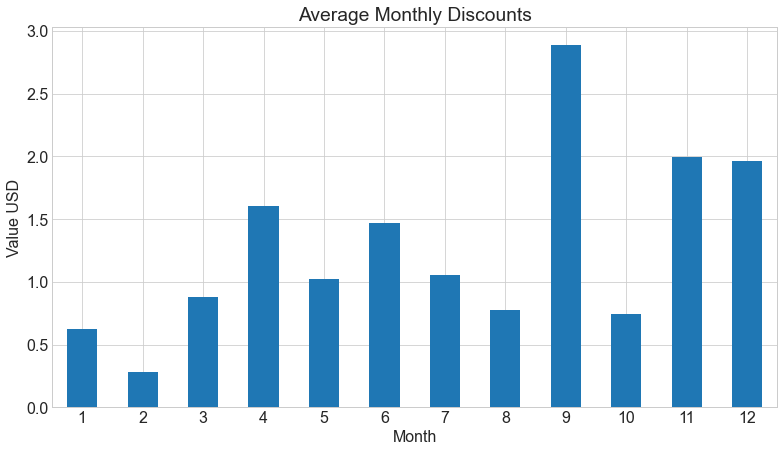

In [75]:
ax = train.groupby(train.index.month).discount.mean().plot.bar()
ax.tick_params('x', rotation=0)
ax.set(title='Average Monthly Discounts', xlabel='Month', ylabel='Value USD')

#### Discount Weekly sum 

<AxesSubplot:title={'center':'Average Weekly Discounts'}, xlabel='order_date'>

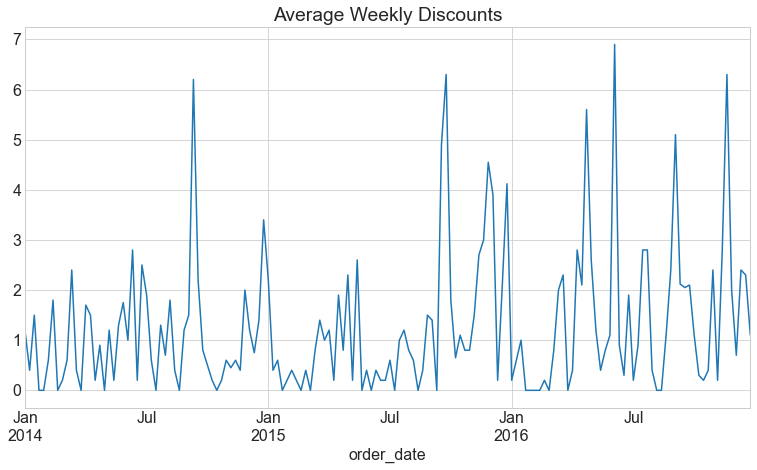

In [76]:
y = train.discount
y.resample('W').mean().plot(title='Average Weekly Discounts')


#### Discount Quarterly Average of weekly discount sum

<AxesSubplot:title={'center':'Average Quarterly Discounts'}, xlabel='order_date'>

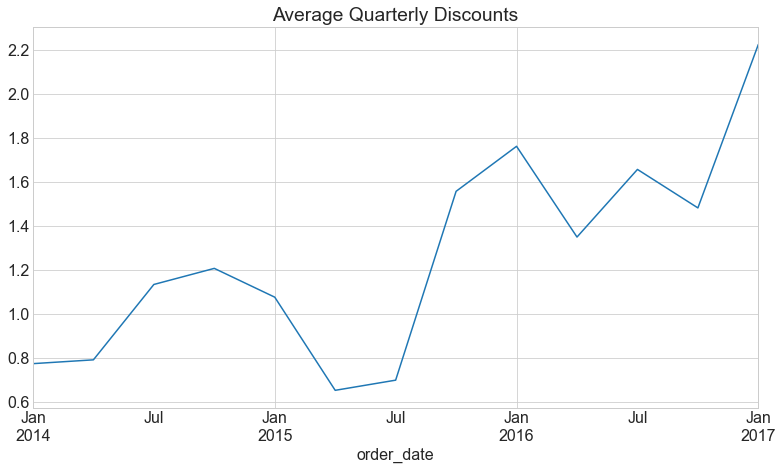

In [77]:
y.resample('3M').mean().plot(title='Average Quarterly Discounts')

#### One more plot with the values resampled in various modalities

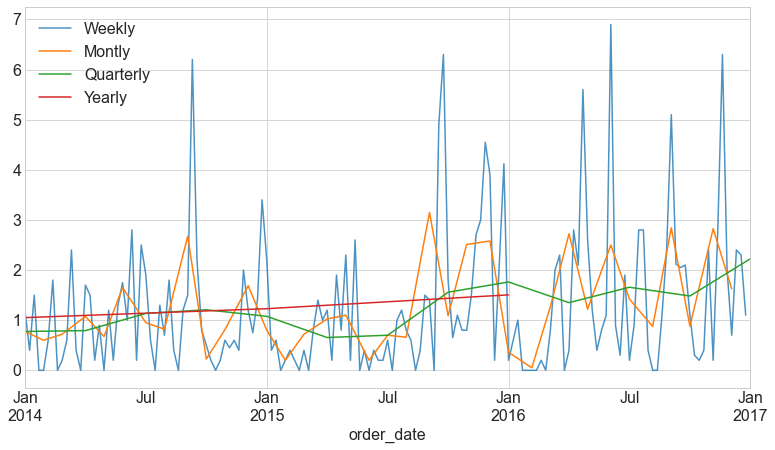

In [78]:
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('3M').mean().plot(label='Quarterly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()


#### Seasonal Decomposition

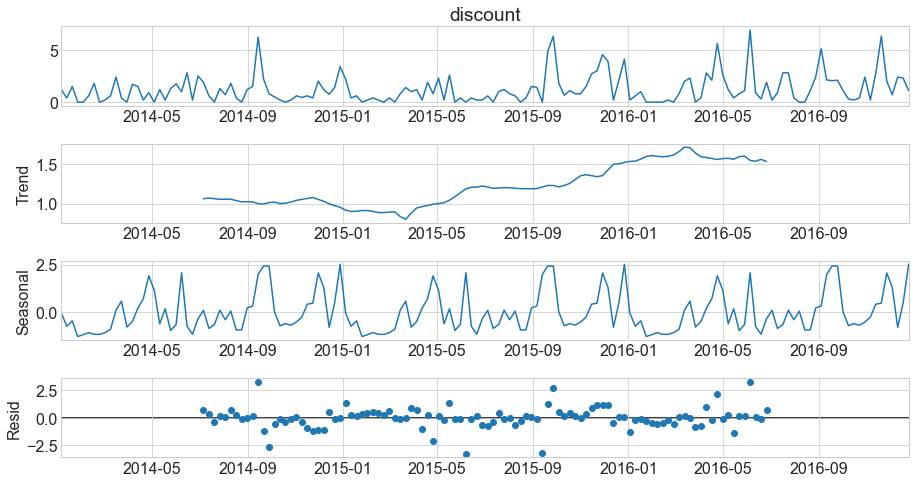

In [79]:
result = sm.tsa.seasonal_decompose(y)
result.plot()
None

#### Let's re-explore the data. 
The values gave us an idea but let's try to get the average values per week and not added just for our Discounts.



In [80]:
from acquire import *
from prepare import clean_columns

Acquire the data

In [81]:
df = AcquireSuperstore().get_data()
df.head()

Reading from .csv file.


Product ID Customer ID  Region ID  Category ID        Order ID  \
0  FUR-BO-10001798    CG-12520          1            1  CA-2016-152156   
1  FUR-CH-10000454    CG-12520          1            2  CA-2016-152156   
2  OFF-LA-10000240    DV-13045          2            3  CA-2016-138688   
3  FUR-TA-10000577    SO-20335          1            4  US-2015-108966   
4  OFF-ST-10000760    SO-20335          1            5  US-2015-108966   

   Order Date   Ship Date       Ship Mode    Segment        Country  ...  \
0  2016-11-08  2016-11-11    Second Class   Consumer  United States  ...   
1  2016-11-08  2016-11-11    Second Class   Consumer  United States  ...   
2  2016-06-12  2016-06-16    Second Class  Corporate  United States  ...   
3  2015-10-11  2015-10-18  Standard Class   Consumer  United States  ...   
4  2015-10-11  2015-10-18  Standard Class   Consumer  United States  ...   

  Postal Code     Sales  Quantity  Discount    Profit         Category  \
0     42420.0  261.9600       2.0      0.00   41.9136        Furniture   
1     42420.0  731.9400       3.0      0.00  219.5820        Furniture   
2     90036.0   14.6200       2.0      0.00    6.8714  Office Supplies   
3     33311.0  957.5775       5.0      0.45 -383.0310        Furniture   
4     33311.0   22.3680       2.0      0.20    2.5164  Office Supplies   

   Sub-Category Region Name    Customer Name  \
0     Bookcases       South      Claire Gute   
1        Chairs       South      Claire Gute   
2        Labels        West  Darrin Van Huff   
3        Tables       South   Sean O'Donnell   
4       Storage       South   Sean O'Donnell   

                                        Product Name  
0                  Bush Somerset Collection Bookcase  
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  
2  Self-Adhesive Address Labels for Typewriters b...  
3      Bretford CR4500 Series Slim Rectangular Table  
4                     Eldon Fold 'N Roll Cart System  

[5 rows x 22 columns]

Clean dataframe using previously used function

In [82]:
df = clean_columns(df)
df.head()

ship_mode      segment        country        city     state  \
order_date                                                                     
2014-01-04  Standard Class  Home Office  United States  Naperville  Illinois   
2014-01-04  Standard Class  Home Office  United States  Naperville  Illinois   
2014-01-04  Standard Class  Home Office  United States  Naperville  Illinois   
2014-01-09  Standard Class     Consumer  United States      Laredo     Texas   
2014-01-09  Standard Class     Consumer  United States      Laredo     Texas   

              sales  quantity  discount   profit         category  \
order_date                                                          
2014-01-04   11.784       3.0       0.2   4.2717  Office Supplies   
2014-01-04    3.540       2.0       0.8  -5.4870  Office Supplies   
2014-01-04  272.736       3.0       0.2 -64.7748  Office Supplies   
2014-01-09   31.200       3.0       0.2   9.7500       Technology   
2014-01-09    9.344       2.0       0.2   1.1680  Office Supplies   

           sub_category region_name  customer_name  \
order_date                                           
2014-01-04       Labels     Central  Phillina Ober   
2014-01-04      Binders     Central  Phillina Ober   
2014-01-04      Storage     Central  Phillina Ober   
2014-01-09  Accessories     Central  Melanie Seite   
2014-01-09          Art     Central  Melanie Seite   

                                          product_name  
order_date                                              
2014-01-04                                   Avery 508  
2014-01-04  GBC Standard Plastic Binding Systems Combs  
2014-01-04               SAFCO Boltless Steel Shelving  
2014-01-09             Memorex Micro Travel Drive 8 GB  
2014-01-09                                  Newell 312

How many rows do not have a discount

In [83]:
df[df.discount ==0]

ship_mode      segment        country           city  \
order_date                                                              
2014-01-10  Standard Class    Corporate  United States    Springfield   
2014-01-10  Standard Class    Corporate  United States    Springfield   
2014-01-11     First Class     Consumer  United States          Dover   
2014-01-13    Second Class    Corporate  United States   Bossier City   
2014-01-13    Second Class    Corporate  United States   Bossier City   
...                    ...          ...            ...            ...   
2017-12-28  Standard Class     Consumer  United States  New York City   
2017-12-28  Standard Class     Consumer  United States  New York City   
2017-12-28  Standard Class     Consumer  United States  New York City   
2017-12-30  Standard Class     Consumer  United States  New York City   
2017-12-30  Standard Class  Home Office  United States       Columbus   

                state   sales  quantity  discount   profit         category  \
order_date                                                                    
2014-01-10   Virginia   51.94       1.0       0.0  21.2954        Furniture   
2014-01-10   Virginia    2.89       1.0       0.0   1.3583  Office Supplies   
2014-01-11   Delaware    9.94       2.0       0.0   3.0814        Furniture   
2014-01-13  Louisiana  572.58       6.0       0.0  34.3548  Office Supplies   
2014-01-13  Louisiana    5.64       3.0       0.0   2.7072  Office Supplies   
...               ...     ...       ...       ...      ...              ...   
2017-12-28   New York   72.45       7.0       0.0  34.7760  Office Supplies   
2017-12-28   New York   14.85       3.0       0.0   4.0095       Technology   
2017-12-28   New York   13.96       4.0       0.0   6.4216  Office Supplies   
2017-12-30   New York   90.93       7.0       0.0   2.7279       Technology   
2017-12-30    Indiana  209.30       2.0       0.0  56.5110  Office Supplies   

           sub_category region_name      customer_name  \
order_date                                               
2014-01-10  Furnishings       South     Anthony Jacobs   
2014-01-10       Labels       South     Anthony Jacobs   
2014-01-11  Furnishings        East        Seth Vernon   
2014-01-13      Storage       South    Chris Selesnick   
2014-01-13      Binders       South    Chris Selesnick   
...                 ...         ...                ...   
2017-12-28       Labels        East  Jennifer Ferguson   
2017-12-28       Phones        East  Jennifer Ferguson   
2017-12-28    Fasteners        East  Jennifer Ferguson   
2017-12-30       Phones        East  Patrick O'Donnell   
2017-12-30   Appliances     Central        Chuck Clark   

                                                 product_name  
order_date                                                     
2014-01-10  Howard Miller 11-1/2" Diameter Ridgewood Wall ...  
2014-01-10                                          Avery 482  
2014-01-11    DAX Value U-Channel Document Frames, Easel Back  
2014-01-13    Fellowes Stor/Drawer Steel Plus Storage Drawers  
2014-01-13                                 3-ring staple pack  
...                                                       ...  
2017-12-28                                          Avery 473  
2017-12-28  Cush Cases Heavy Duty Rugged Cover Case for Sa...  
2017-12-28                   OIC Bulk Pack Metal Binder Clips  
2017-12-30                          Gear Head AU3700S Headset  
2017-12-30  Eureka The Boss Plus 12-Amp Hard Box Upright V...  

[810 rows x 14 columns]

How many rows have a discount

In [84]:
df[df.discount >0]

ship_mode      segment        country           city  \
order_date                                                              
2014-01-04  Standard Class  Home Office  United States     Naperville   
2014-01-04  Standard Class  Home Office  United States     Naperville   
2014-01-04  Standard Class  Home Office  United States     Naperville   
2014-01-09  Standard Class     Consumer  United States         Laredo   
2014-01-09  Standard Class     Consumer  United States         Laredo   
...                    ...          ...            ...            ...   
2017-12-28  Standard Class     Consumer  United States     Round Rock   
2017-12-30  Standard Class     Consumer  United States  New York City   
2017-12-30  Standard Class    Corporate  United States      Fairfield   
2017-12-30  Standard Class    Corporate  United States      Fairfield   
2017-12-30  Standard Class     Consumer  United States  New York City   

                 state     sales  quantity  discount   profit  \
order_date                                                      
2014-01-04    Illinois   11.7840       3.0      0.20   4.2717   
2014-01-04    Illinois    3.5400       2.0      0.80  -5.4870   
2014-01-04    Illinois  272.7360       3.0      0.20 -64.7748   
2014-01-09       Texas   31.2000       3.0      0.20   9.7500   
2014-01-09       Texas    9.3440       2.0      0.20   1.1680   
...                ...       ...       ...       ...      ...   
2017-12-28       Texas   78.8528       2.0      0.32 -11.5960   
2017-12-30    New York  323.1360       4.0      0.20  12.1176   
2017-12-30  California   13.9040       2.0      0.20   4.5188   
2017-12-30  California   20.7200       2.0      0.20   6.4750   
2017-12-30    New York   52.7760       3.0      0.20  19.7910   

                   category sub_category region_name      customer_name  \
order_date                                                                
2014-01-04  Office Supplies       Labels     Central      Phillina Ober   
2014-01-04  Office Supplies      Binders     Central      Phillina Ober   
2014-01-04  Office Supplies      Storage     Central      Phillina Ober   
2014-01-09       Technology  Accessories     Central      Melanie Seite   
2014-01-09  Office Supplies          Art     Central      Melanie Seite   
...                     ...          ...         ...                ...   
2017-12-28        Furniture    Bookcases     Central        Greg Hansen   
2017-12-30        Furniture    Bookcases        East  Patrick O'Donnell   
2017-12-30  Office Supplies      Binders        West         Erica Bern   
2017-12-30  Office Supplies      Binders        West         Erica Bern   
2017-12-30  Office Supplies      Binders        East  Patrick O'Donnell   

                                                 product_name  
order_date                                                     
2014-01-04                                          Avery 508  
2014-01-04         GBC Standard Plastic Binding Systems Combs  
2014-01-04                      SAFCO Boltless Steel Shelving  
2014-01-09                    Memorex Micro Travel Drive 8 GB  
2014-01-09                                         Newell 312  
...                                                       ...  
2017-12-28  Bush Westfield Collection Bookcases, Medium Ch...  
2017-12-30  Bush Westfield Collection Bookcases, Fully Ass...  
2017-12-30    Cardinal Slant-D Ring Binder, Heavy Gauge Vinyl  
2017-12-30                Ibico Hi-Tech Manual Binding System  
2017-12-30               Wilson Jones Legal Size Ring Binders  

[924 rows x 14 columns]

Resample discount to a weekly average 

In [85]:
df.discount.resample('W').mean()

order_date
2014-01-05    0.400000
2014-01-12    0.080000
2014-01-19    0.166667
2014-01-26    0.000000
2014-02-02    0.000000
                ...   
2017-12-03    0.133333
2017-12-10    0.118571
2017-12-17    0.242857
2017-12-24    0.056667
2017-12-31    0.107500
Freq: W-SUN, Name: discount, Length: 209, dtype: float64

Assign it to a variable

In [86]:
avg_by_w = df.resample('W').mean()
avg_by_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209 entries, 2014-01-05 to 2017-12-31
Freq: W-SUN
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     198 non-null    float64
 1   quantity  198 non-null    float64
 2   discount  198 non-null    float64
 3   profit    198 non-null    float64
dtypes: float64(4)
memory usage: 8.2 KB


There are some nulls

In [87]:
avg_by_w.isnull().sum()

sales       11
quantity    11
discount    11
profit      11
dtype: int64

Let's fill all those nulls with a 0

In [88]:
avg_by_w = avg_by_w.fillna(0)

verify that it worked

In [89]:
avg_by_w.discount.isnull().sum()

0

In order for the percentages to make more sense let's round to 2 decimals

In [90]:
avg_by_w.discount = avg_by_w.discount.round(2)

Let's see how many weeks we offered a discount

In [91]:
# weeks without a discount(31)
avg_by_w[avg_by_w.discount == 0]

sales  quantity  discount      profit
order_date                                            
2014-01-26  309.900000  4.500000       0.0   72.874583
2014-02-02  240.625000  5.500000       0.0  106.060250
2014-02-23    0.000000  0.000000       0.0    0.000000
2014-03-30    0.000000  0.000000       0.0    0.000000
2014-05-04   28.320000  3.750000       0.0   11.807700
2014-07-20    0.000000  0.000000       0.0    0.000000
2014-08-24    0.000000  0.000000       0.0    0.000000
2014-10-19  312.642000  3.600000       0.0   77.215600
2015-01-25    0.000000  0.000000       0.0    0.000000
2015-02-22    0.000000  0.000000       0.0    0.000000
2015-03-08  299.856667  3.333333       0.0   72.987633
2015-05-24  186.690000  3.000000       0.0   87.744300
2015-06-07    0.000000  0.000000       0.0    0.000000
2015-07-12  224.095000  3.750000       0.0   57.378750
2015-08-16   24.980000  2.666667       0.0   11.394600
2015-09-13  361.725000  5.500000       0.0   10.851750
2016-01-24    7.560000  6.000000       0.0    0.302400
2016-01-31    0.000000  0.000000       0.0    0.000000
2016-02-07  167.949231  3.692308       0.0   54.870531
2016-02-14  146.820000  3.000000       0.0   73.410000
2016-02-28  170.880000  3.000000       0.0   49.555200
2016-03-27  259.265000  3.500000       0.0   18.864700
2016-08-07    0.000000  0.000000       0.0    0.000000
2016-08-14    6.480000  1.000000       0.0    3.110400
2017-01-29  162.896667  2.666667       0.0   20.108767
2017-02-19    0.000000  0.000000       0.0    0.000000
2017-03-05   32.456667  3.333333       0.0    9.791267
2017-03-26    2.910000  1.000000       0.0    1.367700
2017-05-28  301.960000  2.000000       0.0   33.215600
2017-07-30  178.325000  4.500000       0.0   49.252000
2017-08-13    0.000000  0.000000       0.0    0.000000

In [92]:
# weeks with a discount (178)
avg_by_w[avg_by_w.discount > 0]

sales  quantity  discount     profit
order_date                                           
2014-01-05   96.020000  2.666667      0.40 -21.996700
2014-01-12   21.062800  1.800000      0.08   7.330620
2014-01-19  176.358222  3.777778      0.17  35.625967
2014-02-09   65.921600  3.800000      0.12  25.254520
2014-02-16   46.202667  2.333333      0.60 -13.317333
...                ...       ...       ...        ...
2017-12-03  296.563375  4.708333      0.13   3.576858
2017-12-10  246.785229  3.542857      0.12  32.134257
2017-12-17   33.369714  2.714286      0.24 -21.582557
2017-12-24  342.060333  4.133333      0.06  85.029860
2017-12-31  122.240300  3.625000      0.11  24.780225

[178 rows x 4 columns]

### Split dataframe manually

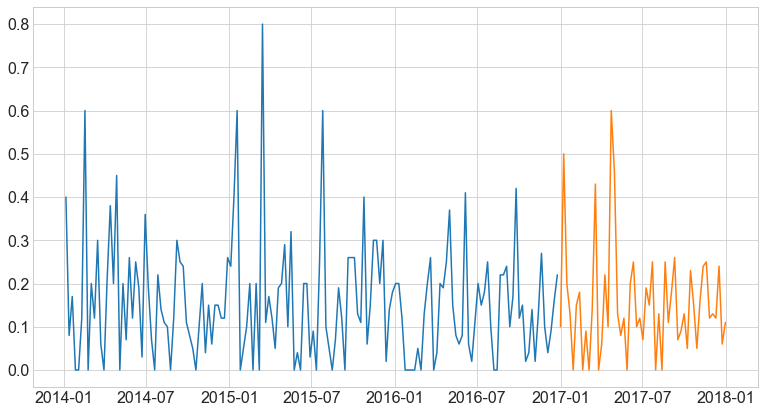

In [93]:
train = avg_by_w[:'2016'] # 2014 - 2016 roughly 75%
test = avg_by_w['2017'] # 2017 roughly 25%
plt.plot(train.index, train.discount)
plt.plot(test.index, test.discount)

#### Monthly Discount Averaged

[Text(0.5, 1.0, 'Average Monthly Discount'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Value USD')]

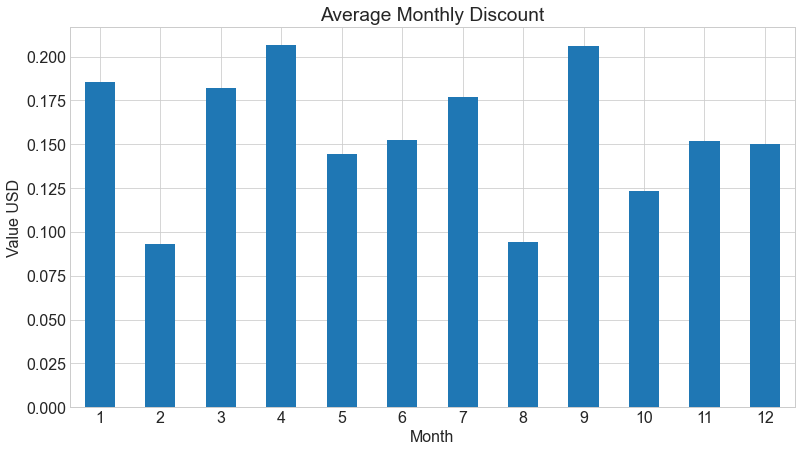

In [94]:
ax = train.groupby(train.index.month).discount.mean().plot.bar()
ax.tick_params('x', rotation=0)
ax.set(title='Average Monthly Discount', xlabel='Month', ylabel='Value USD')

In [95]:
y = train.discount
y.head()

order_date
2014-01-05    0.40
2014-01-12    0.08
2014-01-19    0.17
2014-01-26    0.00
2014-02-02    0.00
Freq: W-SUN, Name: discount, dtype: float64

<AxesSubplot:title={'center':'Average Weekly Discount'}, xlabel='order_date'>

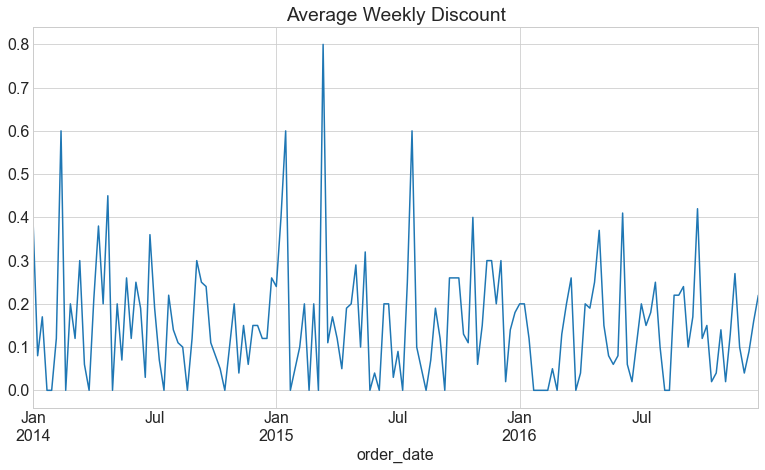

In [96]:
y.resample('W').mean().plot(title='Average Weekly Discount')

<AxesSubplot:title={'center':'Average Quarterly Discount'}, xlabel='order_date'>

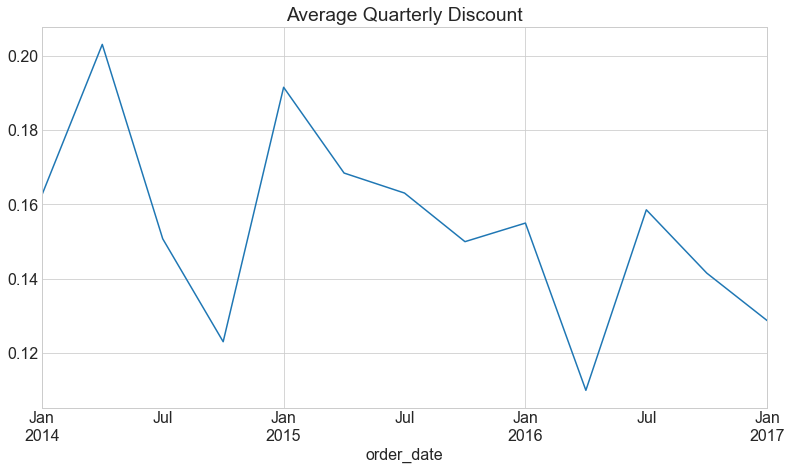

In [97]:
y.resample('3M').mean().plot(title='Average Quarterly Discount')

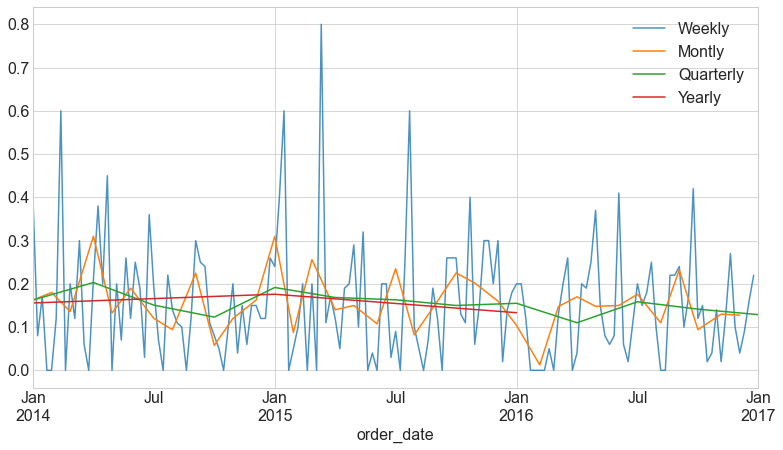

In [98]:
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('3M').mean().plot(label='Quarterly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()

Seasonal Decompose

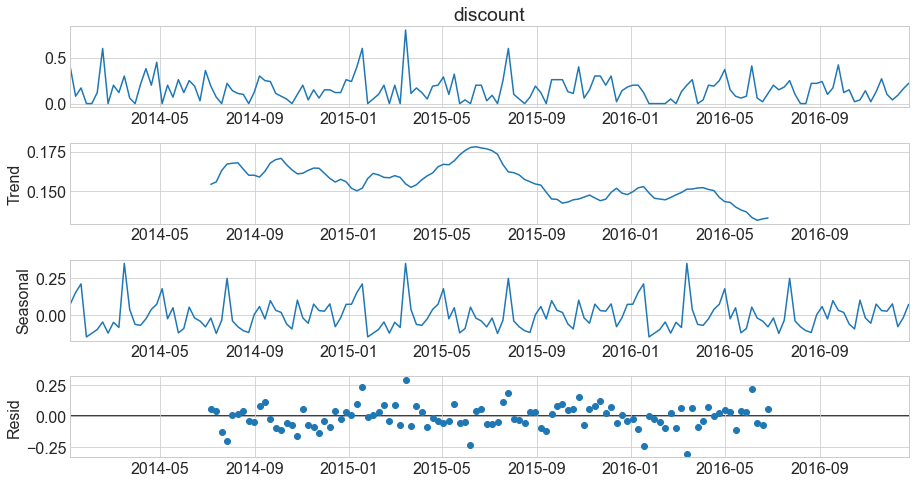

In [99]:
result = sm.tsa.seasonal_decompose(y)
result.plot()
None

---
## Removing Outliers

We're going to remove the outliers to make charts more uniform and see what comes up from it

In [100]:
by_week, east, west, central, south, office_supplies, furniture, technology =  wrangle_remove_outliers()

Reading from .csv file.


Using the function made to remove outliers let's get exploring

In [101]:
by_week.head()

sales  quantity  discount    profit
order_date                                       
2014-01-05  288.060       8.0       1.2  -65.9901
2014-01-12  105.314       9.0       0.4   36.6531
2014-01-19  367.904      22.0       1.5   27.5829
2014-01-26   91.530      17.0       0.0   30.9983
2014-02-02  481.250      11.0       0.0  212.1205

After looking at the data let's verify that there are no null values

In [102]:
by_week.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209 entries, 2014-01-05 to 2017-12-31
Freq: W-SUN
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     209 non-null    float64
 1   quantity  209 non-null    float64
 2   discount  209 non-null    float64
 3   profit    209 non-null    float64
dtypes: float64(4)
memory usage: 8.2 KB


Let's split the data and make some of the same chart we've been doing for comparison

#### First we'll re explore discounts

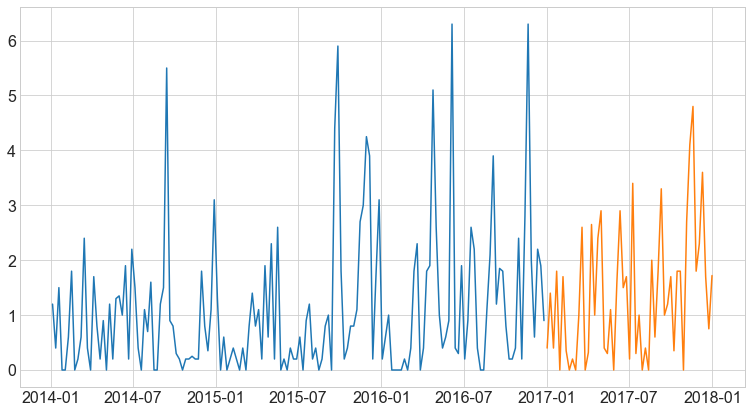

In [103]:
train = by_week[:'2016'] # 2014 - 2016 roughly 75%
test = by_week['2017'] # 2017 roughly 25%
plt.plot(train.index, train.discount)
plt.plot(test.index, test.discount)

[Text(0.5, 1.0, 'No Outliers Average Monthly Discount'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Value USD')]

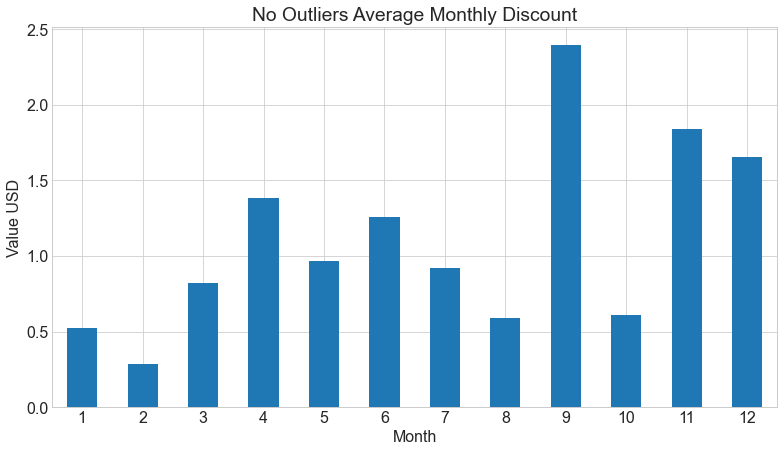

In [104]:
ax = train.groupby(train.index.month).discount.mean().plot.bar()
ax.tick_params('x', rotation=0)
ax.set(title='No Outliers Average Monthly Discount', xlabel='Month', ylabel='Value USD')

<AxesSubplot:title={'center':'No Outliers Weekly Average Discount Sum'}, xlabel='order_date'>

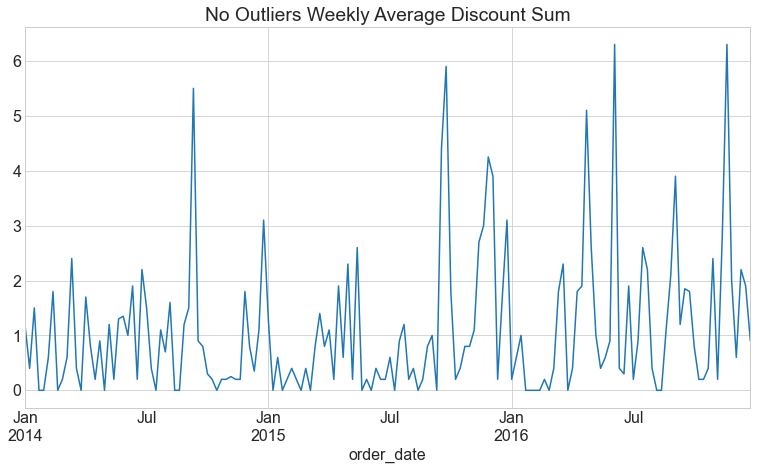

In [105]:
y = train.discount
y.resample('W').mean().plot(title= 'No Outliers Weekly Average Discount Sum')

<AxesSubplot:title={'center':' No Outliers Quarterly Average Discount Sum'}, xlabel='order_date'>

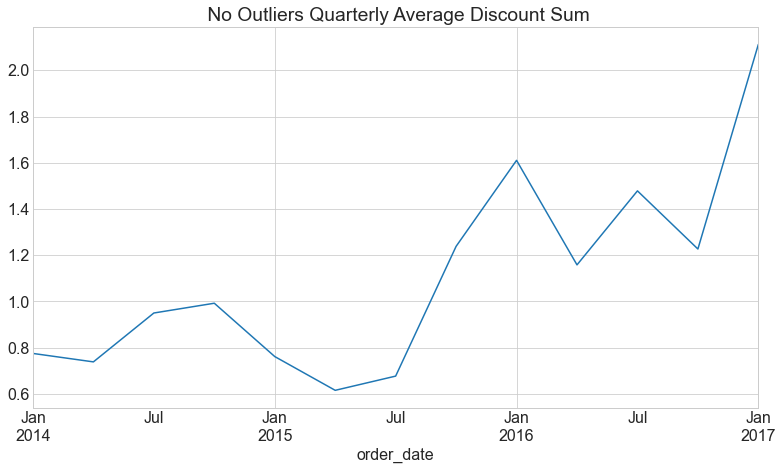

In [106]:
y.resample('3M').mean().plot(title= ' No Outliers Quarterly Average Discount Sum')

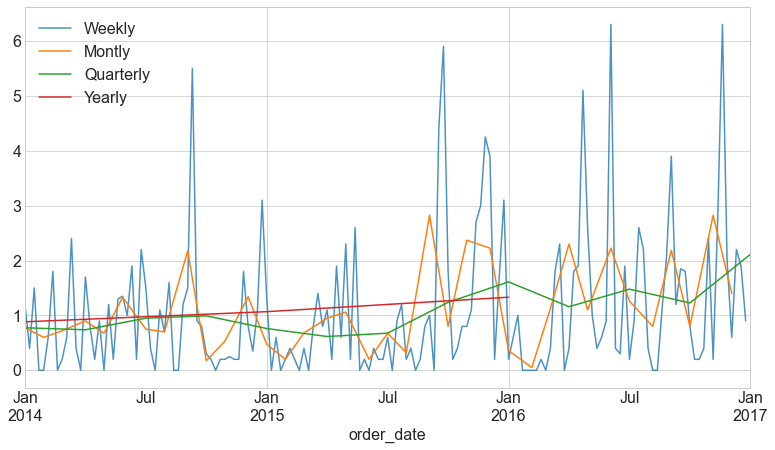

In [107]:
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('3M').mean().plot(label='Quarterly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()

Seasonal decomposition

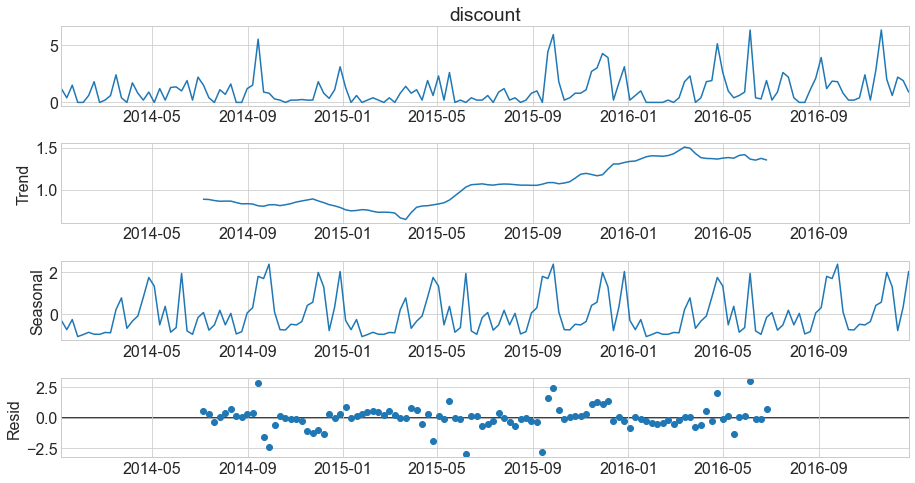

In [108]:
result = sm.tsa.seasonal_decompose(y)
result.plot()
None

### Takeaways:
- Without the outliers there is a a much closer plot to the seasonal
- The Trend is going up
- Much more regular than before

#### Now let's re explore sales

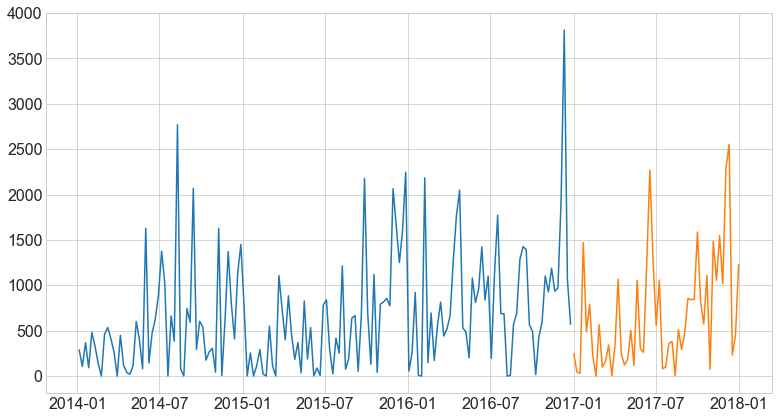

In [109]:
plt.plot(train.index, train.sales)
plt.plot(test.index, test.sales)



[Text(0.5, 1.0, ' No Outliers Average Monthly Sales'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Value USD')]

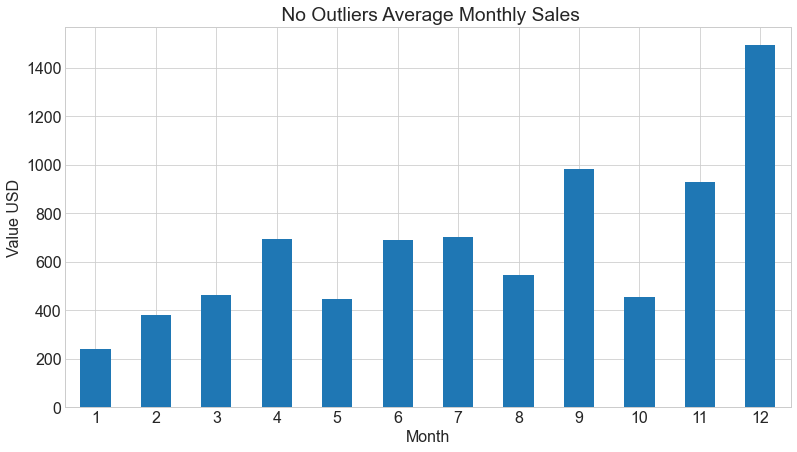

In [110]:
ax = train.groupby(train.index.month).sales.mean().plot.bar()
ax.tick_params('x', rotation=0)
ax.set(title=' No Outliers Average Monthly Sales', xlabel='Month', ylabel='Value USD')


<AxesSubplot:title={'center':' No Outliers Weekly Average Sales'}, xlabel='order_date'>

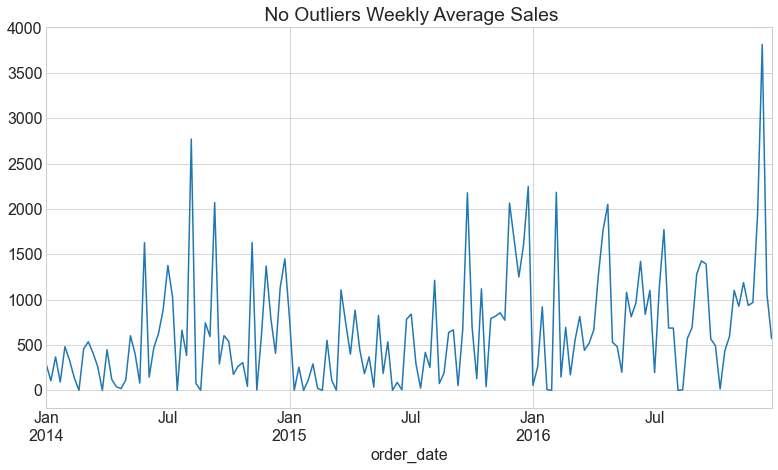

In [111]:
y = train.sales
y.resample('W').mean().plot(title=' No Outliers Weekly Average Sales')

<AxesSubplot:title={'center':' No OutliersQuarterly Average Sales '}, xlabel='order_date'>

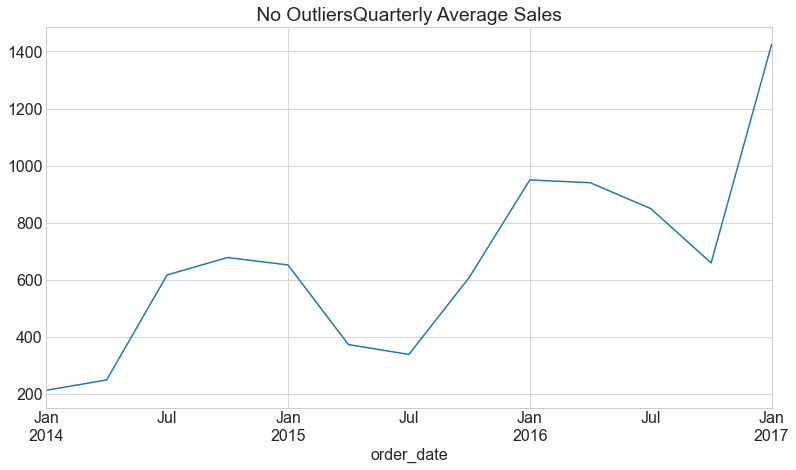

In [112]:
y.resample('3M').mean().plot(title= ' No OutliersQuarterly Average Sales ')


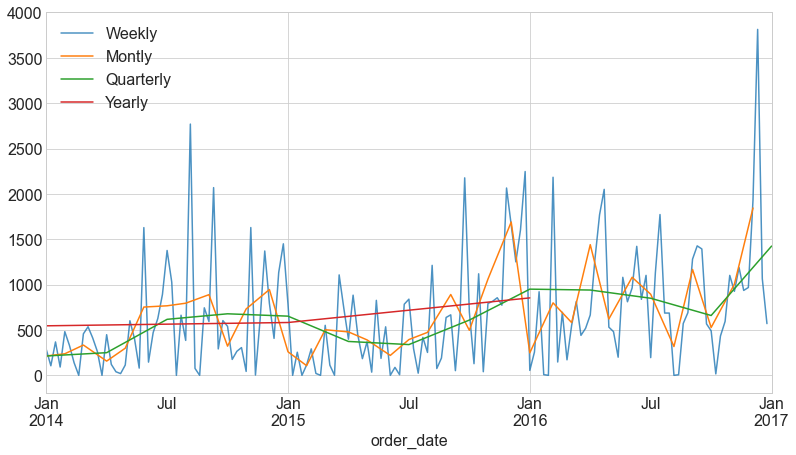

In [113]:
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('3M').mean().plot(label='Quarterly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()


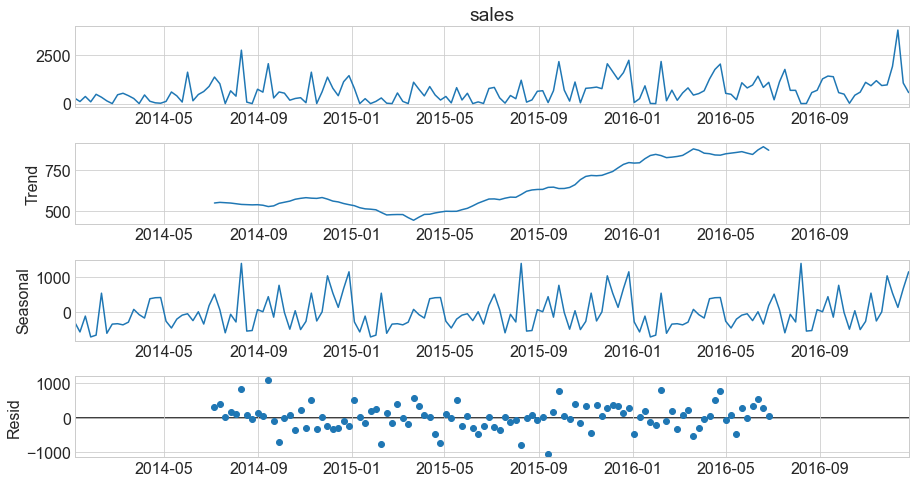

In [114]:
result = sm.tsa.seasonal_decompose(y)
result.plot()
None

### Takeaways:
- Without the outlieres there is a a much closer plot to the seasonal
- The Trend is going up
- Much more regular than before